# Unbalanced Optimal Transport for signed measures


In [1]:
import sys
# sys.path.append('../../')
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
from matplotlib import gridspec

### Function definitions

In [2]:
def div0(x,y):
    """
    Special x/y with convention x/0=0 
    """
    return np.divide(x, y, out=np.zeros_like(x), where=y!=0)

def mul0(x,y):
    """
    Return x*y with the convention 0*Inf = 0
    """
    return np.multiply(x, y, out=np.zeros_like(x), where=~np.isinf(y))

def proxdiv(F,s,u,eps,params):
    """
    Proxdiv operator of the divergence function F
    
    F: String description of the target function
    s: 
    u: 
    eps: epsilon parameter of the entropic regularization
    params: List of parameters of the corresponding F
             
    F = 'KL' --> params[0] = lda ; params[1] = p
    """
    
    if F == 'KL':
        lda = params[0]
        p = params[1]
        # return div0(p,s)**(lda/(lda+eps)) * np.exp(-u/(lda+eps))
        return div0(p,s*np.exp(u/lda))**(lda/(lda+eps))
    
    if F == 'TV':
        lda = params[0]
        p = params[1]
        term1 = np.exp((- u + lda)/eps)
        #print(u.shape)
        #print(term1.shape)
        #print(p.shape)
        #print(s.shape)
        #print((np.exp((-lda - u)/eps)).shape)
        #print((div0(p,s)).shape)
        term2 = np.maximum(np.exp((-lda - u)/eps) , div0(p,s))
        return np.minimum(term1,term2)
        
    else:
        print('Not recognized function.')
        return
    
def fdiv(F,x,p,dx,params):
    """
    Divergence function F
    
    F: String description of the divergence function
    x: Test distribution (KL_F(x|p))
    p: Reference distribution (KL_F(x|p))
    dx: discretization vector
    params: List of parameters of the corresponding F
            
    F = 'KL' --> params[0] = lda
    """
     
    if F == 'KL':
        lda = params[0]
        return lda*np.sum( mul0(dx , ( mul0(x , np.log(div0(x,p))) - x + p)) )
    
    elif F == 'TV':
        lda = params[0]
        return lda*np.sum( mul0(dx , abs(x-p)) )
        
    else:
        print('Not recognized function.')
        return
    
def fdiv_c(F,x,p,dx,params):
    """
    Convex conjugate of the divergence function F
    
    F: String description of the divergence function
    x: Test distribution (KL_F(x|p))
    p: Reference distribution (KL_F(x|p))
    dx: discretization vector
    params: List of parameters of the corresponding F
             
    F = 'KL' --> params[0] = lda
    """
    
    if F == 'KL':
        lda = params[0]
        return lda*np.sum( mul0(p * dx , np.exp(x/lda) - 1) )
    
    elif F == 'TV':
        lda = params[0]
        return lda*np.sum( mul0(dx , np.minimum(p, np.maximum(-p, mul0(p,x/lda)))) )
        
    else:
        print('Not recognized function.')
        return
    
def simple_scalingAlg(C,Fun,p,q,eps,dx,dy,n_max):
    """
    Simple implementation for solving Unbalanced OT problems
    
    C: Cost matrix
    Fun: List defining the function and its lambda parameter. e.i. Fun = ['KL', 0.01]
    p: Source distribution 
    q: target dstribution
    eps: epsilon parameter
    dx: discretizaiton vector in x / np.shape(dx) = (nJ,1)
    dy: discretization vector in y / np.shape(dy) = (nJ,1)
    n_max: Max number of iterations
    """

    # Init
    nI = C.shape[0]
    nJ = C.shape[1]
    a_t = np.ones([nI,1])
    b_t = np.ones([nJ,1])
    R = np.zeros([nI,nJ])
    pdgap = np.zeros([n_max,1])
    params = []
    F = Fun[0] 
    lda = Fun[1] # define lambda parameter value
    
    K_t = np.exp(C/(-eps))
    
    # Main Loop
    for it in range(n_max): # -> Use for and cutting condition
        params = [lda, p]
        a_t = proxdiv(F,(K_t@(b_t*dy)),0.,eps,params)

        params = [lda, q]
        b_t = proxdiv(F,(K_t.T@(a_t*dx)),0.,eps,params)

        # Gap calculation
        R = (np.tile(a_t,nJ)*K_t)*(np.tile(b_t,nI).T)
        param_p = [lda]
        primal = fdiv(F,np.dot(R,dy),p,dx,param_p) + fdiv(F,np.dot(R.T,dx),q,dy,param_p) + \
            eps/(nI*nJ) * np.sum( mul0(R , np.log(div0(R,K_t))) - R + K_t )
        dual = - fdiv_c(F,-eps*np.log(a_t),p,dx,param_p) - fdiv_c(F,-eps*np.log(b_t),q,dy,param_p) -\
            eps/(nI*nJ) * np.sum(R-K_t)
        pdgap[it] = primal-dual

    
    R = (np.tile(a_t,nJ)*K_t)*(np.tile(b_t,nI).T)
    
    return R, pdgap, a_t, b_t 

def make_1D_gauss(n, m, s):
    """
    Return a 1D histogram for a gaussian distribution (n bins, mean m and std s)
    Parameters
    ----------
    n : int
        number of bins in the histogram
    m : float
        mean value of the gaussian distribution
    s : float
        standard deviaton of the gaussian distribution
    Returns
    -------
    h : np.array (n,)
          1D histogram for a gaussian distribution
    """
    x = np.arange(n, dtype=np.float64)
    h = np.exp(-(x - m)**2 / (2 * s**2))
    h = h / h.sum()
    return np.reshape(h,(len(h),1))


def plot1D_mat(a, b, M, title=''):
    """ Plot matrix M  with the source and target 1D distribution

    Creates a subplot with the source distribution a on the left and
    target distribution b on the tot. The matrix M is shown in between.


    Parameters
    ----------
    a : np.array, shape (na,)
        Source distribution
    b : np.array, shape (nb,)
        Target distribution
    M : np.array, shape (na,nb)
        Matrix to plot
    """
    na, nb = M.shape

    gs = gridspec.GridSpec(3, 3)

    xa = np.arange(na)
    xb = np.arange(nb)

    ax1 = plt.subplot(gs[0, 1:])
    plt.plot(xb, b, 'r', label='Target distribution')
    plt.yticks(())
    plt.title(title)

    ax2 = plt.subplot(gs[1:, 0])
    plt.plot(a, xa, 'b', label='Source distribution')
    plt.gca().invert_xaxis()
    plt.gca().invert_yaxis()
    plt.xticks(())

    plt.subplot(gs[1:, 1:], sharex=ax1, sharey=ax2)
    plt.imshow(M, interpolation='nearest')
    plt.axis('off')

    plt.xlim((0, nb))
    plt.tight_layout()
    plt.subplots_adjust(wspace=0., hspace=0.2)


def plot2D_samples_mat(xs, xt, G, thr=1e-8, **kwargs):
    """ Plot matrix M  in 2D with  lines using alpha values

    Plot lines between source and target 2D samples with a color
    proportional to the value of the matrix G between samples.


    Parameters
    ----------
    xs : ndarray, shape (ns,2)
        Source samples positions
    b : ndarray, shape (nt,2)
        Target samples positions
    G : ndarray, shape (na,nb)
        OT matrix
    thr : float, optional
        threshold above which the line is drawn
    **kwargs : dict
        paameters given to the plot functions (default color is black if
        nothing given)
    """
    if ('color' not in kwargs) and ('c' not in kwargs):
        kwargs['color'] = 'k'
    mx = G.max()
    for i in range(xs.shape[0]):
        for j in range(xt.shape[0]):
            if G[i, j] / mx > thr:
                plt.plot([xs[i, 0], xt[j, 0]], [xs[i, 1], xt[j, 1]],
                        alpha=G[i, j] / mx, **kwargs)


In [7]:
def full_scalingAlg(C,Fun,p,q,eps_vec,dx,dy,n_max,verb=True,eval_rate=10):
    """
    Implementation for solving Unbalanced OT problems that includes the log-domain stabilization
    
    C: Cost matrix
    Fun: List defining the function and its lambda parameter. e.i. Fun = ['KL', 0.01]
    p: Source distribution 
    q: target dstribution
    eps_vec: epsilon parameter (If scalar, the same epsilons is used throughout the algorithm.
        If vector, the epsilons are equally distributed along the iterations forcing an absorption 
        at each epsilon change.)
    dx: discretizaiton vector in x / np.shape(dx) = (nJ,1)
    dy: discretization vector in y / np.shape(dy) = (nJ,1)
    n_max: Max number of iterations
    """
    
    # Initialization
    nI = C.shape[0]
    nJ = C.shape[1]
    a_t = np.ones([nI,1])
    u_t = np.zeros([nI,1])
    b_t = np.ones([nJ,1])
    v_t = np.zeros([nJ,1])
    R = np.zeros([nI,nJ])
    pdgap = np.zeros([n_max,1])
    params = []
    F = Fun[0] 
    lda = Fun[1] # define lambda parameter value
    eps_ind = 0 # index for the chosen epsilons
    eval_rate = eval_rate
    n_evals = np.floor(n_max/eval_rate).astype(int)
    param_p = [lda]
    primals = np.zeros((n_evals,1))
    duals = np.zeros((n_evals,1))
    pdgaps = np.zeros((n_evals,1))
    
    if np.isscalar(eps_vec):
        eps = eps_vec
        eps_tot = 1
    else:
        eps = eps_vec[eps_ind] # select the first epsilon to use
        eps_tot = len(eps_vec)
    
    K_t = np.exp(C/(-eps))
    
    
    # Main Loop
    for it in range(n_max): # -> Use for and cutting condition
        params = [lda, p]
        a_t = proxdiv(F,(K_t@(b_t*dy)),u_t,eps,params)

        params = [lda, q]
        b_t = proxdiv(F,(K_t.T@(a_t*dx)),v_t,eps,params)
        
        if verb == True:
            # Check the primal, dual and primal-dual gap
            if it%eval_rate == 0:
                it_eval = 0
                R = (np.tile(a_t,nJ)*K_t)*(np.tile(b_t,nI).T) # Reconstruct map
                primal = fdiv(F,R@dy,p,dx,param_p) + fdiv(F,R.T@dx,q,dy,param_p) + \
                    eps/(nI*nJ) * np.sum( mul0(R , np.log(div0(R,K_t))) - R + K_t )
                dual = - fdiv_c(F,-eps*np.log(a_t),p,dx,param_p) - fdiv_c(F,-eps*np.log(b_t),q,dy,param_p) -\
                    eps/(nI*nJ) * np.sum(R-K_t)
                pdgap = primal-dual

                # print("primal = %f \n dual = %f \n pdgap = %f \n"%(primal,dual,pdgap))

                primals[it_eval] = primal
                duals[it_eval] = dual
                pdgaps[it_eval] = pdgap

                it_eval += 1
        
        # stabilizations
        #print('it/n_max = %f , (eps_ind+1)/len(eps_vec) = %f'%(it/n_max , (eps_ind+1)/len(eps_vec)))
        if np.max([abs(a_t),abs(b_t)]) > 1e50 or (it/n_max) > (eps_ind+1)/eps_tot:# or it == n_max-1:
            """
            primal = fdiv(F,R@dy,p,dx,param_p) + fdiv(F,R.T@dx,q,dy,param_p) + \
                eps/(nI*nJ) * np.sum( mul0(R , np.log(div0(R,K_t))) - R + K_t )
            dual = - fdiv_c(F,-eps*np.log(a_t),p,dx,param_p) - fdiv_c(F,-eps*np.log(b_t),q,dy,param_p) -\
                eps/(nI*nJ) * np.sum(R-K_t)
            pdgap = primal-dual
            """
            
            # absorb
            u_t = u_t + eps*np.log(a_t)
            v_t = v_t + eps*np.log(b_t)
            
            if (it/n_max) > (eps_ind+1)/eps_tot:
                eps_ind += 1 
                eps = eps_vec[eps_ind]
                
            # update K
            K_t = np.exp((np.tile(u_t,nJ) + np.tile(v_t,nI).T - C)/(eps))
        
            a_t = np.ones([nI,1]) # Not really needed
            b_t = np.ones([nJ,1])
            print('it = %d , eps = %f'%(it,eps))

    R = (np.tile(a_t,nJ)*K_t)*(np.tile(b_t,nI).T) # Reconstruct map
    
    return R, a_t, b_t, primals, duals, pdgaps
    

def signed_GWD(C,Fun,p,q,eps_vec,dx,dy,n_max,verb=True,eval_rate=10):
    
    p_pos = np.zeros(p.shape)
    p_neg = np.zeros(p.shape)
    q_pos = np.zeros(q.shape)
    q_neg = np.zeros(q.shape)

    sign_p = np.sign(p)
    sign_q = np.sign(q)

    p_pos[sign_p>0] = p[sign_p>0]
    p_neg[sign_p<0] = -p[sign_p<0]
    q_pos[sign_q>0] = q[sign_q>0]
    q_neg[sign_q<0] = -q[sign_q<0]

    p_tilde = p_pos + q_neg
    q_tilde = q_pos + p_neg 
    
    return full_scalingAlg(C,Fun,p_tilde,q_tilde,eps_vec,dx,dy,n_max,verb,eval_rate)       
               

# Test 1

- Basic test on the balanced and unbalanced case using the algorithm with log-stabilization
- The KL constraints are used

In [8]:
n_p = 100
n_q = 100
n_max = 10000
#eps = 1.e-2
eps_vec = np.logspace(-1.,-6.,10)
Fun = ['KL', 1.e1]
X,Y = np.linspace(0,1,n_p), np.linspace(0,1,n_q)

p =  make_1D_gauss(n_p, np.floor(3*n_p/4.), 1.)*1 + make_1D_gauss(n_p, np.floor(1*n_p/8.), 2.)*0.5
q =  make_1D_gauss(n_q, np.floor(7*n_q/8.), 2.)*1

dx = np.ones([n_p,1])/n_p
dy = np.ones([n_q,1])/n_q

C = np.zeros([n_p,n_q],dtype=np.float64)

dist_f2 = lambda a,b : (a-b)**2
dist_f1 = lambda a,b : abs(a-b)
dist_fcos = lambda a,b : -2*np.log(np.cos(np.pi*0.5*np.minimum(1.,np.abs(a-b)/.2)))
#dist_fcos = lambda a,b : np.minimum(1.,np.abs(a-b)/.2)

for it1 in range(n_p):
    for it2 in range(n_q):
        C[it1,it2] = dist_f1(X[it1],Y[it2])


R, a_t, b_t, primals, duals, pdgaps = full_scalingAlg(C,Fun,p,q,eps_vec,dx,dy,n_max)


/var/folders/hj/cjr82nxn52g6pymvdqp74p5m0000gp/T/ipykernel_80827/3896765082.py:64: RuntimeWarning: divide by zero encountered in log
  return lda*np.sum( mul0(dx , ( mul0(x , np.log(div0(x,p))) - x + p)) )
/var/folders/hj/cjr82nxn52g6pymvdqp74p5m0000gp/T/ipykernel_80827/3890346337.py:61: RuntimeWarning: divide by zero encountered in log
  eps/(nI*nJ) * np.sum( mul0(R , np.log(div0(R,K_t))) - R + K_t )
/var/folders/hj/cjr82nxn52g6pymvdqp74p5m0000gp/T/ipykernel_80827/3890346337.py:62: RuntimeWarning: divide by zero encountered in log
  dual = - fdiv_c(F,-eps*np.log(a_t),p,dx,param_p) - fdiv_c(F,-eps*np.log(b_t),q,dy,param_p) -\
/var/folders/hj/cjr82nxn52g6pymvdqp74p5m0000gp/T/ipykernel_80827/3890346337.py:87: RuntimeWarning: divide by zero encountered in log
  v_t = v_t + eps*np.log(b_t)
/var/folders/hj/cjr82nxn52g6pymvdqp74p5m0000gp/T/ipykernel_80827/3890346337.py:86: RuntimeWarning: divide by zero encountered in log
  u_t = u_t + eps*np.log(a_t)


it = 1001 , eps = 0.027826
it = 1002 , eps = 0.027826
it = 2001 , eps = 0.007743
it = 2002 , eps = 0.007743
it = 3001 , eps = 0.002154
it = 3002 , eps = 0.002154
it = 4001 , eps = 0.000599
it = 4002 , eps = 0.000599
it = 5001 , eps = 0.000167
it = 5002 , eps = 0.000167
it = 6001 , eps = 0.000046
it = 6002 , eps = 0.000046
it = 7001 , eps = 0.000013
it = 7002 , eps = 0.000013
it = 8001 , eps = 0.000004
it = 8002 , eps = 0.000004
it = 9001 , eps = 0.000001
it = 9002 , eps = 0.000001


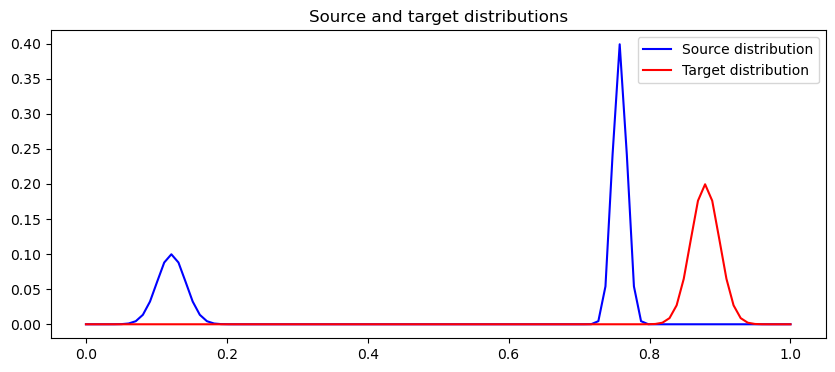

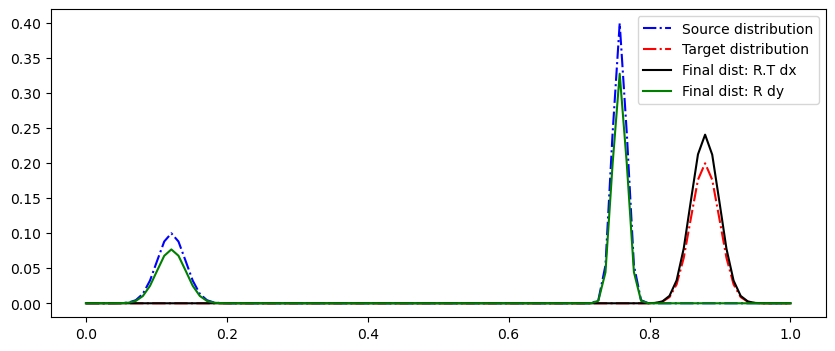

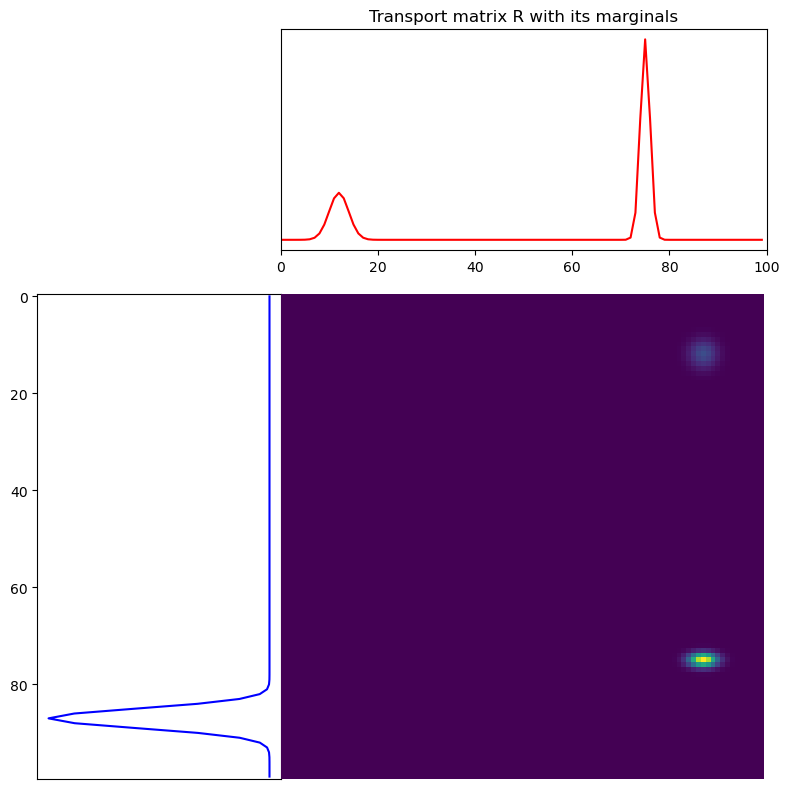

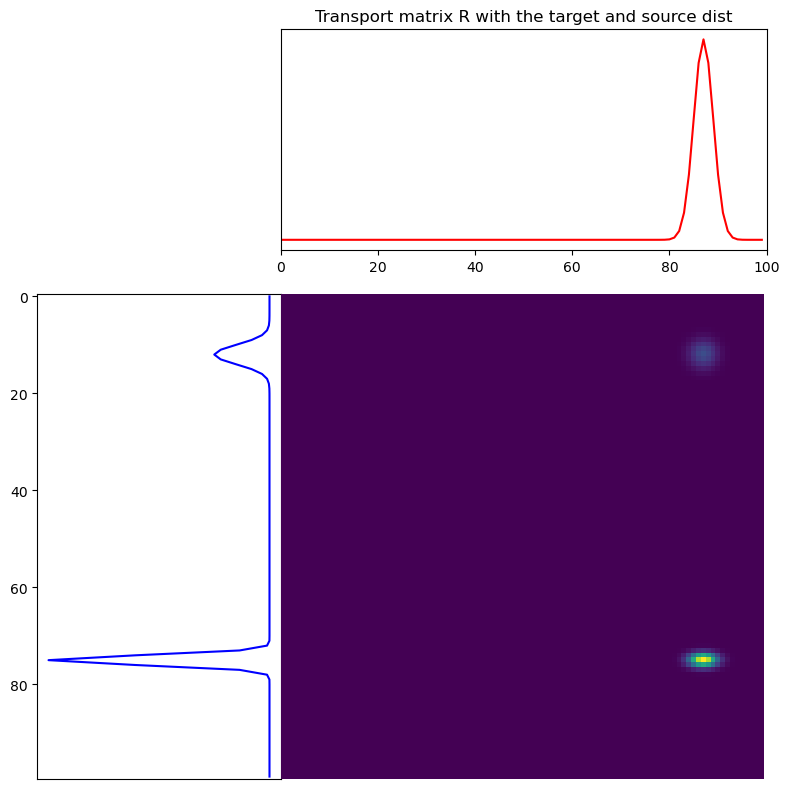

In [9]:
# Plots
# Plot target and source distributions
plt.figure( figsize=(10, 4))
plt.plot(X,p, 'b-', label='Source distribution')
plt.plot(Y,q, 'r-', label='Target distribution')
plt.legend()
plt.title('Source and target distributions')

# Direct output transport plan
# Plot results
plt.figure( figsize=(10, 4))
plt.plot(X,p, 'b-.', label='Source distribution')
plt.plot(Y,q, 'r-.', label='Target distribution')
plt.plot(X, R.T@dx, 'k-', label='Final dist: R.T dx')
plt.plot(Y, R@dy, 'g-', label='Final dist: R dy')
plt.legend()

# Plot transport plan with its marginals
plt.figure( figsize=(8, 8))
plot1D_mat(R.T@dx, R@dy, R, 'Transport matrix R with its marginals')

# Plot transport plan with its marginals
plt.figure( figsize=(8, 8))
plot1D_mat(p, q, R, 'Transport matrix R with the target and source dist')

# Test 2

- Basic test on the balanced and unbalanced case using the algorithm with log-stabilization.
- The TV regularization is used

In [10]:
n_p = 100
n_q = 100
n_max = 100000
#eps_vec = 1.e-3
eps_vec = np.logspace(-1.,-4.,10)
lda = 1.e1
Fun = ['TV', lda]
X,Y = np.linspace(0,1,n_p), np.linspace(0,1,n_q)

p =  make_1D_gauss(n_p, np.floor(3*n_p/4.), 2.)*1 + make_1D_gauss(n_p, np.floor(1*n_p/8.), 2.)*0.5
q =  make_1D_gauss(n_q, np.floor(7*n_q/8.), 2.)*1

dx = np.ones([n_p,1])/n_p
dy = np.ones([n_q,1])/n_q

C = np.zeros([n_p,n_q],dtype=np.float64)

dist_f2 = lambda a,b : (a-b)**2
dist_f1 = lambda a,b : abs(a-b)
dist_fcos = lambda a,b : -2*np.log(np.cos(np.pi*0.5*np.minimum(1.,np.abs(a-b)/.2)))
#dist_fcos = lambda a,b : np.minimum(1.,np.abs(a-b)/.2)

for it1 in range(n_p):
    for it2 in range(n_q):
        C[it1,it2] = dist_f1(X[it1],Y[it2])


R, a_t, b_t, primals, duals, pdgaps = full_scalingAlg(C,Fun,p,q,eps_vec,dx,dy,n_max)

it = 10001 , eps = 0.046416
it = 10002 , eps = 0.046416
it = 20001 , eps = 0.021544
it = 20002 , eps = 0.021544


/var/folders/hj/cjr82nxn52g6pymvdqp74p5m0000gp/T/ipykernel_80827/3896765082.py:35: RuntimeWarning: overflow encountered in exp
  term1 = np.exp((- u + lda)/eps)


it = 30001 , eps = 0.010000
it = 30002 , eps = 0.010000
it = 40001 , eps = 0.004642
it = 40002 , eps = 0.004642
it = 50001 , eps = 0.002154
it = 50002 , eps = 0.002154


/var/folders/hj/cjr82nxn52g6pymvdqp74p5m0000gp/T/ipykernel_80827/3890346337.py:61: RuntimeWarning: divide by zero encountered in log
  eps/(nI*nJ) * np.sum( mul0(R , np.log(div0(R,K_t))) - R + K_t )


it = 60001 , eps = 0.001000
it = 60002 , eps = 0.001000
it = 70001 , eps = 0.000464
it = 70002 , eps = 0.000464
it = 80001 , eps = 0.000215
it = 80002 , eps = 0.000215
it = 90001 , eps = 0.000100
it = 90002 , eps = 0.000100


/var/folders/hj/cjr82nxn52g6pymvdqp74p5m0000gp/T/ipykernel_80827/1340580505.py:14: RuntimeWarning: divide by zero encountered in log
  eps/(nI*nJ) * np.sum( mul0(R , np.log(div0(R,K_t))) - R + K_t )


*******************
Transport details
Elements transported = 2719
target |q - R.Tdx|_1 = 0.101492
source |p - Rdy|_1 = 0.398508
Int(p) = 1.50 , |p| = 1.50
Int(q) = 1.00 , |q| = 1.00
primal = 5.003444e-02 , dual = -1.014921e-07 , gap = 5.003454e-02


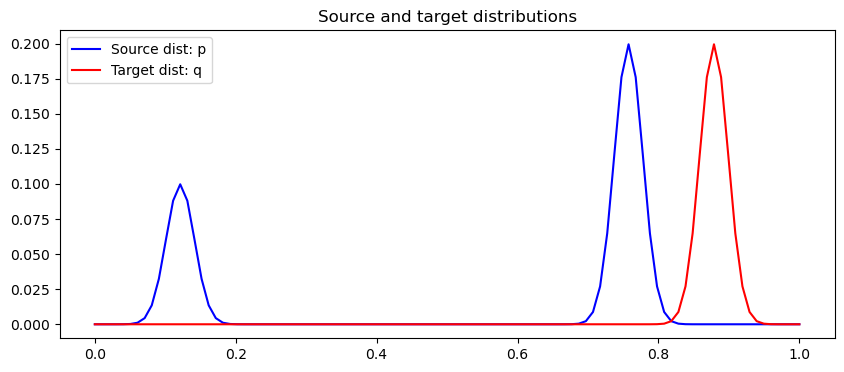

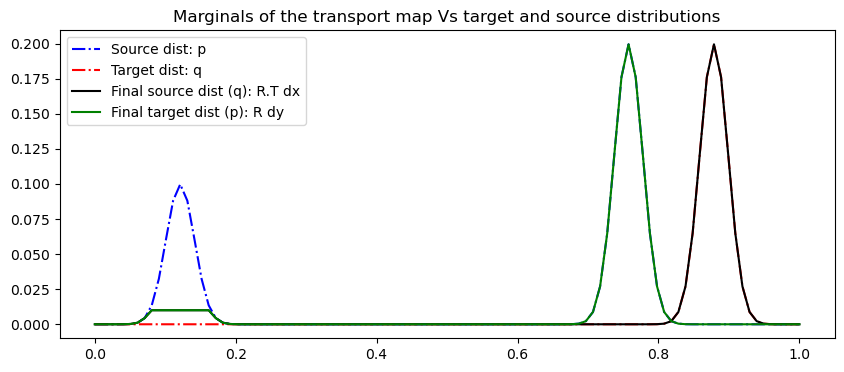

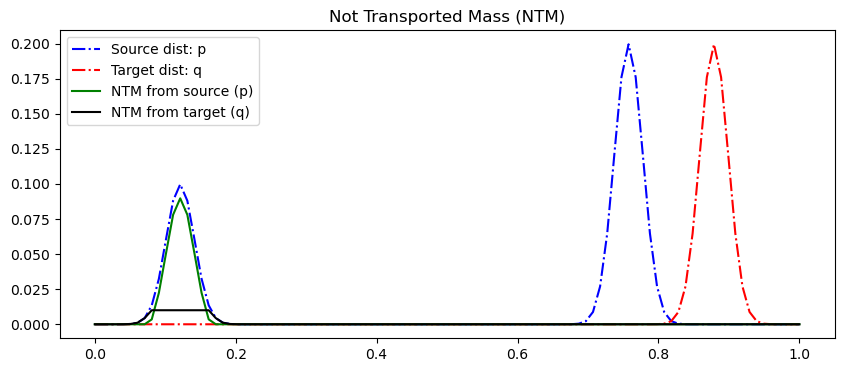

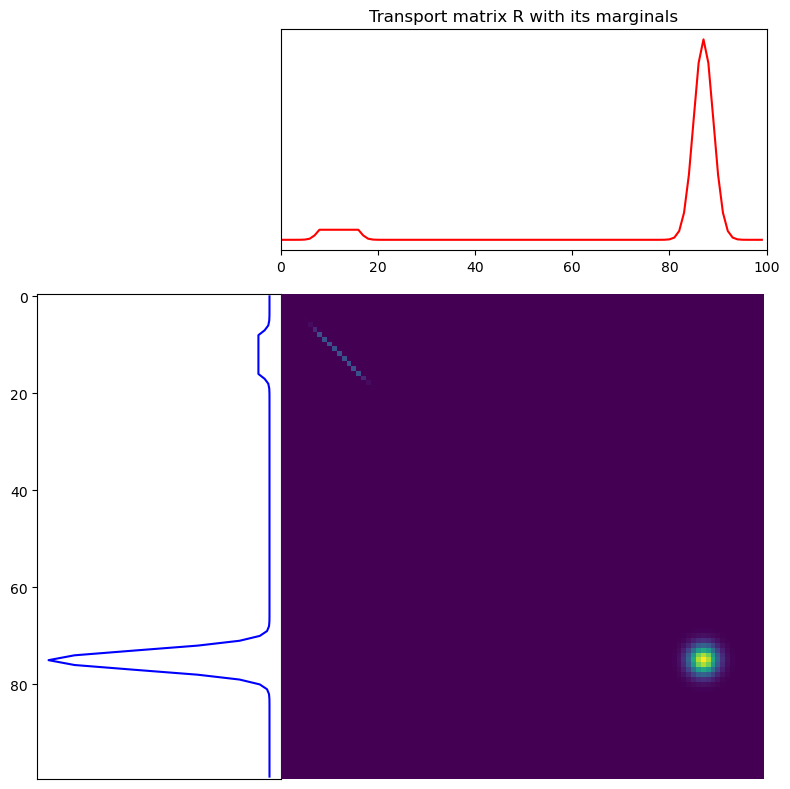

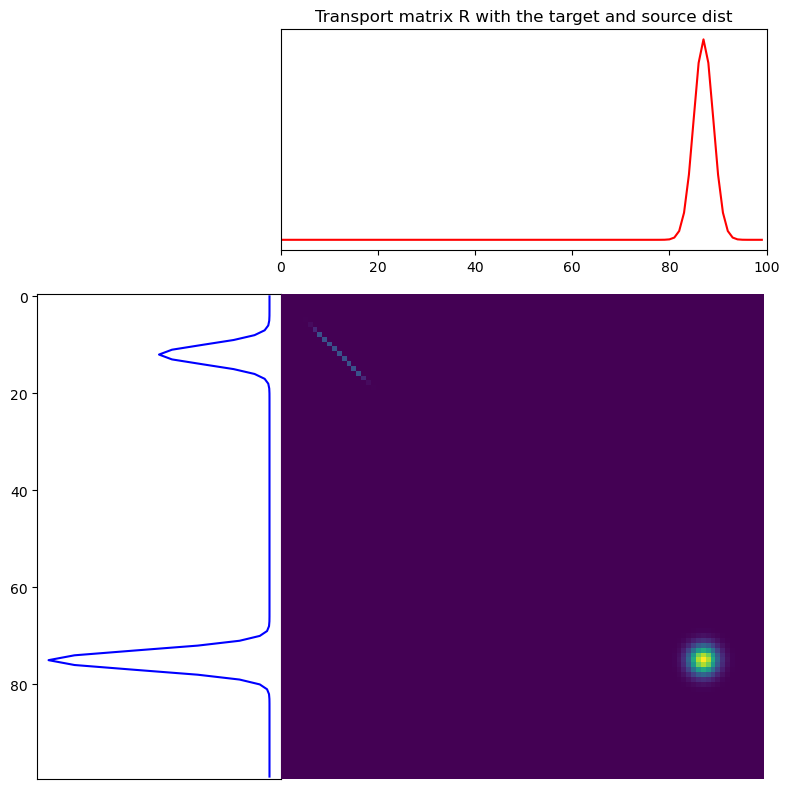

In [11]:
#--------------------------------------#
# Print info
if np.isscalar(eps_vec):
    eps = eps_vec
else:
    eps = eps_vec[-1] # select the last epsilon to use
    
K_t = np.exp(C/(-eps))
F = Fun[0] 
param_p = [lda]
nI = n_p ; nJ = n_q

primal = fdiv(F,R@dy,p,dx,param_p) + fdiv(F,R.T@dx,q,dy,param_p) + \
    eps/(nI*nJ) * np.sum( mul0(R , np.log(div0(R,K_t))) - R + K_t )
dual = - fdiv_c(F,-eps*np.log(a_t),p,dx,param_p) - fdiv_c(F,-eps*np.log(b_t),q,dy,param_p) -\
    eps/(nI*nJ) * np.sum(R-K_t)
pdgap = primal-dual

print('*******************')
print('Transport details')
#print('Transport cost <P,C> = %f'%(np.sum(R*C)))
print('Elements transported = %d'%(np.count_nonzero(R - np.diag(np.diagonal(R)))))
print('target |q - R.Tdx|_1 = %f'%(np.sum(abs(q-R.T@dx))))
print('source |p - Rdy|_1 = %f'%(np.sum(abs(p-R@dy))))
print('Int(p) = %.2f , |p| = %.2f'%(np.sum(p),np.sum(abs(p))))
print('Int(q) = %.2f , |q| = %.2f'%(np.sum(q),np.sum(abs(q))))
print('primal = %e , dual = %e , gap = %e'%(primal,dual,pdgap))



#--------------------------------------#
# Plots

# target and source distributions
plt.figure( figsize=(10, 4))
plt.plot(X,p, 'b-', label='Source dist: p')
plt.plot(Y,q, 'r-', label='Target dist: q')
plt.legend()
plt.title('Source and target distributions')

# Marginals of the transport map
# target and source distributions
plt.figure( figsize=(10, 4))
plt.plot(X,p, 'b-.', label='Source dist: p')
plt.plot(Y,q, 'r-.', label='Target dist: q')
plt.plot(X, R.T@dx, 'k-', label='Final source dist (q): R.T dx')
plt.plot(Y, R@dy, 'g-', label='Final target dist (p): R dy')
plt.legend()
plt.title('Marginals of the transport map Vs target and source distributions')

# not transported mass
# Positive value means mass that is left over.
# Negative values means that mass is missing.
plt.figure( figsize=(10, 4))
plt.plot(X,p, 'b-.', label='Source dist: p')
plt.plot(Y,q, 'r-.', label='Target dist: q')
plt.plot(X, p - R@dy, 'g-', label='NTM from source (p)')
plt.plot(Y, R.T@dx - q, 'k-', label='NTM from target (q)')
plt.legend()
plt.title('Not Transported Mass (NTM)')

# Plot transport plan with its marginals
plt.figure( figsize=(8, 8))
plot1D_mat(R@dy, R.T@dx, R, 'Transport matrix R with its marginals')

# Plot transport plan with its marginals
plt.figure( figsize=(8, 8))
plot1D_mat(p, q, R, 'Transport matrix R with the target and source dist')



# Regularized Generalized Wasserstein Distance for signed measures

- Use of the sacling algorithm proposed by L. Chizat [1] and the idea of Piccoli & Rossi [2]
- The algorithm is used with the log-stabilization implementation
- The TV regularization is used

(The notation will follow [1])

The $\lambda$ (*lda*) parameter is the one that regulates the cost of the transport in comparison to the creation/destruction of mass. 
The upper the $\lambda$, the higher the cost of creation/destruction.

----------
### Basic formulation

Given a small regularization parameter $\epsilon>0$, we consider the primal problem that consists of a regularized transportation problem with some constraints on the transport matrix $\gamma$,

\begin{equation}
\tag{$1$}
	\min_{\gamma \in \mathcal{M}^n(X \times Y)}
		 \langle c , \gamma \rangle + \mathcal{F}_1(P^X_\# \gamma) + \mathcal{F}_2(P^Y_\# \gamma)
		 + \epsilon \, \mathcal{H}(\gamma),
\end{equation}

where $\mathcal{M}(T)$ is the vector space of non-negative finite Radon measures on a topological space $T$. For $\gamma \in \mathcal{M}^n(X \times Y)$, $P^X_\# \gamma$ denotes its first marginal and $P^Y_\# \gamma$ denotes its second marginal. Some notation:

$$ \langle r,s \rangle := \sum_{i=1}^n \int_{X \times Y} r_i(x,y)\, s_i(x,y) \text{d} x \text{d} y $$

$$(P^X_\# r)_i (x) = \int_Y r_i(x,y) \text{d} y \quad \text{and} \quad (P^Y_\# r)_i (y) = \int_X r_i(x,y) \text{d} x  \, .$$

The entropy term can be written as:

$$ \mathcal{H}(\gamma) := \sum_{k=1}^n \int_{X\times Y} r_k(\log(r_k)-1) \text{d}x \text{d}y\,$$

The equation of the primal problem can be rewritten up to a constant as

\begin{equation}
	\min_{\gamma \in \mathcal{M}^n(X \times Y)}
		 \mathcal{F}_1(P^X_\# \gamma) + \mathcal{F}_2(P^Y_\# \gamma)
		 + \epsilon \sum_{k=1}^n \mathcal{KL}(\gamma_k|e^{-c_k/\epsilon} \text{d}x \text{d}y).
\end{equation}


*****

### Reformulation using densities and duality

Citing [1]: "From the definition of the entropy $\mathcal{H}$, any feasible $\gamma$ of the generic problem $(1)$ admits an $\text{L}_1$ density with respect to the reference measure $\text{d}x \text{d}y$." The primal equation can read as variational problem on measurable functions as follows,

\begin{equation}
\tag{$P_{\epsilon}$}
	\min_{r \in \text{L}^1(X\times Y)^n} 
		 F_1( P^X_\# r )
		 + F_2( P^Y_\# r  )
		 + \epsilon \text{KL}(r |K),
\end{equation}

from where $F_1(s) := \mathcal{F}_1(s\text{d} x)$, $F_2(s) := \mathcal{F}_2(s\text{d} y)$ and $K(x,y) := \exp(\frac{-c(x,y)}{\epsilon})$ (defined component-wise).

The dual problem, obtained using the Fenchel-Rockafellar Theorem, is formulatedd as follows,

\begin{equation}
\tag{$D_{\epsilon}$}
\sup_{ (u,v) \in \text{L}^{\infty}(X)^n\times \text{L}^{\infty}(Y)^n } - F_1^*(-u)-F_2^*(-v) - 
\epsilon \langle e^{(u \oplus v)/\epsilon}-1 , K \rangle ,
\end{equation}

where $u \oplus v : (x,y) \mapsto u(x)+v(y)$.

We will define two linear operators $\mathcal{K}$ and $\mathcal{K}^{T}$ defined for $a:X\to [0,\infty[^n$ and $b:Y\to [0,\infty[^n$:

\begin{align}
	\tag{$2$}
	(\mathcal{K} b)(x)_k := \int_Y K_k(x,y)  b_k(y) \text{d} y \quad \text{and} \quad
	(\mathcal{K}^{T} a)(y)_k := \int_X K_k(x,y) a_k(x) \text{d} x\, .
\end{align}

The dual problem ($D_{\epsilon}$) can be solved using alternating maximizations:

\begin{equation}
\left\{\begin{aligned}
u^{(l+1)}  &= \arg\max_{u\in L^{\infty}(X)^n} - F_1^*(-u) - \epsilon \langle e^{\frac{u}\epsilon}, \mathcal{K} e^{\frac{v^{(l)}}\epsilon} \rangle_X \,, \\
v^{(l+1)}  &= \arg\max_{v\in L^{\infty}(Y)^n} - F_2^*(-v) - \epsilon  \langle e^{\frac{v}\epsilon}, \mathcal{K}^{T} e^{ \frac{u^{(l+1)}}\epsilon} \rangle_Y \,,
\end{aligned}
\right.
\end{equation}

where to solve them we can relate the primal and the dual of each minimization with the Fenchel-Rockafellar (FR) Theorem:

$$ \sup_{u \in L^{\infty}(X)^n} -F_1^*(-u) - \epsilon \langle e^{u / \epsilon}, \mathcal{K} e^{v^{(l)} / \epsilon} \rangle
= \min_{s \in L^{1}(X)^n} F_1(s) + \epsilon \text{KL} (s|\mathcal{K} e^{v^{(l)} / \epsilon}) $$

The minimizer of the right part is $s^{\star} := \text{prox}^{\text{KL}}_{F_1/\epsilon}(\mathcal{K} e^{v^{(l)} / \epsilon})$ and the FR Theorem states that the minimizer $s^{\star}$ belongs to the subdiferential of $u \mapsto \langle e^{u / \epsilon}, \mathcal{K} e^{v^{(l)} / \epsilon} \rangle$ at the point $u^{\star}$, the maximizer of the left part. Being this:

\begin{equation}
s^\star(x) = e^{u^\star(x)/\epsilon} \cdot (\mathcal{K} e^{v^{(l)}/\epsilon})(x) .
\end{equation}


So, defining this new variables:

$$ (a^{(l)},b^{(l)})=(e^{u^{(l)}/\epsilon},e^{v^{(l)}/\epsilon}) $$

and recalling the expression of $s^\star(x)$ we can write (omiting the dependence on $x$):

$$ \text{prox}^{\text{KL}}_{F_1/\epsilon}(\mathcal{K} e^{v^{(l)} / \epsilon}) = a^{(l+1)} \cdot (\mathcal{K} e^{v^{(l)}/\epsilon}), $$

$$ a^{(l+1)} = \frac{\text{prox}^{\text{KL}}_{F_1/\epsilon}(\mathcal{K} e^{v^{(l)} / \epsilon})}{(\mathcal{K} e^{v^{(l)}/\epsilon})} = \frac{\text{prox}^{\text{KL}}_{F_1/\epsilon}(\mathcal{K} b^{(l)})}{(\mathcal{K} b^{(l)})}. $$


We can define the scaling iterations that will be the central part of the algorithm:

-----------
**Scaling iterations:**

\begin{align}\tag{S}
	a^{(l+1)} := \frac{ 
			\text{prox}^{\text{KL}}_{F_1/\epsilon}(\mathcal{K} b^{(l)})  
		}{
			\mathcal{K} b^{(l)}
		}
		\, , \quad	
	b^{(l+1)} := \frac{ 
			\text{prox}^{\text{KL}}_{F_2/\epsilon}(\mathcal{K}^{\text{T}} a^{(l+1)})  
		}{
			\mathcal{K}^{\text{T}} a^{(l+1)}
		},
\end{align}

---------


where the proximal operator with respect to the $\text{KL}$ divergence goes as follows:

\begin{equation}
\text{prox}^{\text{KL}}_{F_1/\epsilon}(z) := \mathrm{arg}\min_{\substack{s :X \to \mathbb{R}^n \\ \text{measurable}}} F(s) + \epsilon \text{KL}(s|z) \, .
\end{equation}

The new scaling variables $a,b$ relate to the dual variables $u,v$, *under some conditions*, by the following equation:

\begin{equation}
(a^{(l)},b^{(l)})=(e^{u^{(l)}/\epsilon},e^{v^{(l)}/\epsilon}).
\end{equation}

******

## Discrete measures

Now we will consider the case of *discrete* measures. Notation will change to enphasize the discrete data.

The transport map and the cost matrix, $\mathbf{R},\mathbf{C} \in \mathbb{R}^{I\times J}_{+}$, the reference probability measures $\text{d}\mathbf{x} \in \mathbb{R}^{I}_{+}$, $\text{d}\mathbf{y} \in \mathbb{R}^{J}_{+}$ where $\sum \text{d}\mathbf{x} = \sum \text{d}\mathbf{y} = 1$.

The constraints will be total variation distances $\text{TV}(p | q) := |p - q|_{\text{TV}}$ that in practice, for a pair of vectors $p,q \in \mathbb{R}^{n}$ will be $\text{TV}(p | q) := \left\lVert p - q \right\rVert_{1} = \sum_i |p_i - q_i |$.

The Regularized GW "Distance" (RGWD) (*proof* missing for the regularized case) will be defined in the context of discrete positive measures ($\mu \in \mathbb{R}_{+}^{I} , \nu \in \mathbb{R}_{+}^{J}$) as follows:

\begin{equation}
W_{1}^{\lambda, \epsilon}(\mu,\nu) = \min_{\mathbf{R} \in \mathbb{R}^{I\times J}} 
F_1(\mathbf{R}\, \text{d}\mathbf{y})
+F_2( \mathbf{R}^{T}\text{d}\mathbf{x}) + \epsilon \sum_{ij} \overline{\text{KL}}(\mathbf{R}_{i,j}| \mathbf{K}_{i,j}), 
\end{equation}

\begin{equation}
W_{1}^{\lambda, \epsilon}(\mu,\nu) = \min_{\mathbf{R} \in \mathbb{R}^{I\times J}} 
\lambda \left\lVert \mathbf{R}\text{d}\mathbf{y} - \mathbf{\mu} \right\rVert_{1} +
\lambda \left\lVert \mathbf{R}^{T}\text{d}\mathbf{x} - \mathbf{\nu} \right\rVert_{1} + \epsilon \sum_{ij} \overline{\text{KL}}(\mathbf{R}_{i,j}| \mathbf{K}_{i,j}), 
\end{equation}

from where we used that,

\begin{equation}
P^X_\# \mathbf{R} = \mathbf{R}\, \text{d}\mathbf{y}
\quad \text{and} \quad
P^Y_\# \mathbf{R} = \mathbf{R}^{T}\text{d}\mathbf{x},
\end{equation}

\begin{equation}
F_1 : \mathbb{R}^{I} \to \mathbb{R}_{+} \; , \; F_1(\mathbf{x}) = \lambda \left\lVert \mathbf{x} - \mathbf{\mu} \right\rVert_{1}
\quad \text{and} \quad
F_2 : \mathbb{R}^{J} \to \mathbb{R}_{+} \; , \; F_2(\mathbf{y}) = \lambda \left\lVert \mathbf{y} - \mathbf{\nu} \right\rVert_{1} \,,
\end{equation}

also that $\mathbf{K} = (e^{-\mathbf{C}/\epsilon}) \in \mathbb{R}^{I \times J}$, where the exponential operates element-wise, and that the pointwise Kullback-Liebler divergence (conserving [1] notation) is,

\begin{equation}
\overline{\text{KL}}(s|z) := \sum_{k=1}^n s_k \log \left( \frac{s_k}{z_k} \right)-s_k + z_k \,.
\end{equation}

The previous operators defined in equation $(2)$ can be reformulated for the discrete case,


\begin{equation}
\mathcal{K}\,\mathbf{b} = \mathbf{K}(\mathbf{b}\odot \text{d}\mathbf{y})
\quad \text{and} \quad 
\mathcal{K}^{T}\,\mathbf{a} = \mathbf{K}^{T}(\mathbf{a}\odot \text{d}\mathbf{x})\, .
\end{equation}

where,

\begin{equation}
\mathbf{a}^{(l)} = e^{\mathbf{u}^{(l)} / \epsilon}
\quad \text{and} \quad 
\mathbf{b}^{(l)} = e^{\mathbf{v}^{(l)} / \epsilon}\, .
\end{equation}


The proximal operator with the KL divergence for the TV regularization can be expressed as:

\begin{equation}
\text{prox}^{\text{KL}}_{F/\epsilon}(s) = \min \left\{ s \cdot \exp\left\{\frac{\lambda}{\epsilon}\right\}, \max \left\{ s \cdot \exp\left\{\frac{-\lambda}{\epsilon}\right\}, p \right\} \right\}
\end{equation}

\begin{equation}
\text{proxdiv}_{F}(s,u,\epsilon) = \min \left\{ \exp\left\{\frac{\lambda - u}{\epsilon}\right\}, \max \left\{ s \cdot \exp\left\{\frac{-\lambda + u}{\epsilon}\right\}, \frac{p}{s} \right\} \right\}
\end{equation}

The basic scaling algorithm reads as follows:

<p align="center">
  <img src="./imgs/scaling_algo.png?raw=true" width="500" title="hover text">
</p>

where $F_1$ and $F_2$ are the TV regularizations with respect to $\mathbf{\mu}$ and $\mathbf{\nu}$ (the reference measures) respectively.


******

## Signed measures

Now we will consider the RGWD when dealing with signed measures $\mu \in \mathbb{R}^{I}$ , $\nu \in \mathbb{R}^{J}$.

The measures will be decomposed following Jordan's decomposition, that is the minimal one, (it would be the one such that the supports of the positive and negative parts do not overlap) and it reads as follows:

\begin{equation}
\mu = \mu_{+} - \mu_{-}
\quad \text{and} \quad 
\nu = \nu_{+} - \nu_{-}\, ,
\end{equation}

where $\mu_{+},\mu_{-} \in \mathbb{R}^{I}_{+}$ , $\nu_{+},\nu_{-} \in \mathbb{R}^{J}_{+}$ , $\{\text{supp}\{\mu_{+}\} \cap \text{supp}\{\mu_{-}\}\} = \{ \emptyset \}$ and $\{\text{supp}\{\nu_{+}\} \cap \text{supp}\{\nu_{-}\}\} = \{ \emptyset \}$.

The RGWD for signed measures will be defined as follows:

\begin{equation}
\tag{$W$}
\mathbb{W}_{1}^{\lambda, \epsilon}(\mu,\nu) = W_{1}^{\lambda, \epsilon}(\mu_{+} + \nu_{-} , \mu_{-} + \nu_{+}) \, .
\end{equation}

The parameter $\epsilon$ controls the regularization of the Wasserstein distance calculation, while the $\lambda$ parameter plays an important role in the strategy to calculate the distance.

The next figure can add some intuition to the decision of transporting with the strategy in ($W$). The distributions can be partitioned into:


\begin{equation}
\begin{aligned}
\mu^{+}  &= \mu^{+}_{0} + \mu^{+}_{1} + \tilde{\mu}^{+} \,, \quad \nu^{+}  = \nu^{+}_{0} + \nu^{+}_{1} + \tilde{\nu}^{+} \,, \\
\mu^{-}  &= \mu^{-}_{0} + \mu^{-}_{1} + \tilde{\mu}^{-} \,, \quad \nu^{-}  = \nu^{-}_{0} + \nu^{-}_{1} + \tilde{\nu}^{-} \,,
\end{aligned}
\end{equation}

where $\,\mu^{+}_{0}, \mu^{+}_{1}, \mu^{-}_{0}, \mu^{-}_{1} \in \mathbb{R}^{I}_{+}\,$, $\,\nu^{+}_{0}, \nu^{+}_{1}, \nu^{-}_{0}, \nu^{-}_{1} \in \mathbb{R}^{J}_{+}\,$, $\,\tilde{\mu}^{+}, \tilde{\mu}^{-} \in \mathbb{R}^{I}\,$ and $\,\tilde{\nu}^{+}, \tilde{\nu}^{-} \in \mathbb{R}^{J}\,$. Notice that the values with $\tilde{(\cdot)}$ (tilde) can take negative values, depending if there is mass being created or destructed. 

The distance will be calculed as a trasportation that will follow the next illustration. 


<p align="center">
  <img src="./imgs/Transport_partitions_v1.png?raw=true" width="600" title="hover text">
</p>


For example the measure $\mu^{+}$ can have three actions:

- *Classic transportation* from $\mu^{+}_{0}$ to $\nu^{+}_{0}$.
- *Transportation (cancelation)* from $\mu^{+}_{1}$ to $\mu^{-}_{1}$ in order to cancel mass in the $\mu$ signed measure.
- *Creation(+) or Destruction (-)* of mass as $\tilde{\mu}^{+}$ is added to $\mu^{+}$. The sign of $\tilde{\mu}^{+}$ determines if creation or destruction is going on. 




The reference [3] describes some strategies to deal with signed measures and more intuition about the chosen strategy can be found there. Nevertheless, the author only considers the different strategies applied to the original Wasserstein distance. The authors in [2] consider the strategy called "Global cost" from [3] to extend their Generalized Wasserstein Distance (GWD), defined in [4] and conceived to solve the unbalanced optimal transport problem, to now deal with signed measures. 
Here we are using the strategy of [2] which is mostly theoretical without a practical and implementation point of view for the static trasportation problem (in fact, at the end of the article they present a practical application to solve the transport equation with source term, a PDE, and we are not interested in the dynamical formulation for the moment). The problem defined in [2] is regularized following the already classical entropic regularization proposed in [5]. Then, the scaling algorithm proposed in [1] suits perfectly to solve the RGWD problem providing a fast and efficient implementation. 

An interesting property of the RGWD is that, as analyzed in [2] for the unregularized case in the *proof* of the proposition 1 in the 3rd chapter, the  "distance" does not depend on the decomposition (*to be proved for the regularized case*) that is why the RGWD is interesting as it can use the trivial (Jordan) decomposition.

Things to prove:
1. The distance does not depend on the decomposition used.
2. Triangle inequality.
3. Adding the same mass to both sides does not change the distance.



---------------

[[1]](http://arxiv.org/abs/1607.05816) L. Chizat, G. Peyré, B. Schmitzer, and F.-X. Vialard, "Scaling algorithms for unbalanced transport problems", arXiv:1607.05816, 2016.

[[2]](https://hal.archives-ouvertes.fr/hal-01665244/document) Benedetto Piccoli, Francesco Rossi, Magali Tournus. A norm for signed measures, with application to
non local transport equation with source term. 2018. <hal-01665244v2>

[[3]](http://cvgmt.sns.it/media/doc/paper/133/Signed_Final.pdf) E. Mainini,  "A description of transport cost for signed measures", J. Math. Sci. (N.Y.) (2012)

[[4]](https://arxiv.org/pdf/1206.3219.pdf) B. Piccoli and F. Rossi, "Generalized Wasserstein distance and its application to transport equations with source", arXiv:1206.3219, 2012.

[[5]](https://arxiv.org/pdf/1306.0895.pdf) M. Cuturi, "Sinkhorn distances: Lightspeed computation of optimal transport", Advances in Neural Information Processing Systems (NIPS) 26, 2013, pp. 2292–2300.

## Some examples

By choosing the n_ex variable there are some examples to see the behaviour of the norm, when creation, dustruction, cancelation and same sign transportation occur. It is possible to modify the lambda parameter to see the canges.

More examples to be made..

In [12]:
n_p = 100
n_q = 100
n_max = 10000
#eps_vec = 1.e-3
X,Y = np.linspace(0,1,n_p), np.linspace(0,1,n_q)

# Choose the transport example
n_ex = 3

# Transportation examples
if n_ex == 1:
    # Example N1: no transport at all
    eps_vec = np.logspace(-2.,-6.,10)
    lda = 1.e0
    p =  make_1D_gauss(n_p, np.floor(1*n_p/4.), 2.)*(-1) 
    q =  make_1D_gauss(n_q, np.floor(7*n_q/8.), 2.)*1 

elif n_ex == 2:
    # Example N2: positive transport
    eps_vec = np.logspace(-2.,-6.,10)
    lda = 1.e0
    p =  make_1D_gauss(n_p, np.floor(2*n_p/4.), 2.)*1 + make_1D_gauss(n_p, np.floor(2*n_p/4.), 2.)*1 \
    + make_1D_gauss(n_p, np.floor(2*n_p/8.), 4.)*1
    q =  make_1D_gauss(n_q, np.floor(1*n_q/8.), 2.)*1 + make_1D_gauss(n_q, np.floor(6*n_q/8.), 2.)*1 

elif n_ex == 3:
    # Example N3: transport + destruction
    eps_vec = np.logspace(-1.,-4.,10)
    lda = 2.e0
    p =  make_1D_gauss(n_p, np.floor(1*n_p/4.), 2.)*(2) + make_1D_gauss(n_p, np.floor(2*n_p/4.), 2.)*(-0.5) 
    q =  make_1D_gauss(n_q, np.floor(6*n_q/8.), 2.)*1
    
elif n_ex == 4:
    # Example N4: cancelation + transport
    eps_vec = np.logspace(-0.5,-3.,10)
    lda = 1.e1
    p =  make_1D_gauss(n_p, np.floor(2*n_p/8.), 2.)*(2) + make_1D_gauss(n_p, np.floor(4*n_p/8.), 2.)*(-1) 
    q =  make_1D_gauss(n_q, np.floor(6*n_q/8.), 2.)*1

elif n_ex == 5:
    # Example N5: cancelation + creation
    eps_vec = np.logspace(-2.,-4.,10)
    lda = 1.e0
    p =  make_1D_gauss(n_p, np.floor(1*n_p/8.), 2.)*(1) + make_1D_gauss(n_p, np.floor(2.5*n_p/8.), 2.)*(-1) 
    q =  make_1D_gauss(n_q, np.floor(7*n_q/8.), 2.)*1  #+ make_1D_gauss(n_p, np.floor(5.5*n_p/8.), 2.)*(-1)
    
elif n_ex == 6:
    # Example N3: transport + destruction
    eps_vec = np.logspace(0.,-2.,10)
    lda = 1.e-1
    p =  make_1D_gauss(n_p, np.floor(1*n_p/4.), 2.)*(2.5) + make_1D_gauss(n_p, np.floor(2*n_p/4.), 2.)*(2.5) 
    q =  make_1D_gauss(n_q, np.floor(6*n_q/8.), 2.)*4
    
elif n_ex == 7:
    # Example N
    eps_vec = np.logspace(0.,-2.,10)
    lda = 1.e0
    p =  make_1D_gauss(n_p, np.floor(2*n_p/4.), 2.)*(2.0) 
    q =  make_1D_gauss(n_q, np.floor(2*n_q/4.), 2.)*(2.0)
    
elif n_ex == 8:
    # Example N
    eps_vec = np.logspace(1.,-3.,10)
    lda = 1.e3
    p =  make_1D_gauss(n_p, np.floor(2*n_p/4.), 2.)*(2.0) + make_1D_gauss(n_p, np.floor(1*n_p/4.), 1.)*(1.0) 
    q =  make_1D_gauss(n_q, np.floor(2*n_q/4.), 2.)*(2.0) + make_1D_gauss(n_p, np.floor(3*n_p/4.), 1.)*(-1.0) 
    
elif n_ex == 9:
    # Example N
    eps_vec = np.logspace(0.5,-3.5,10)
    lda = 1.e1
    p = make_1D_gauss(n_p, np.floor(1*n_p/4.), 2.)*(1.0) + np.ones((n_p,1))*(0.2)
    q = make_1D_gauss(n_p, np.floor(3*n_p/4.), 2.)*(-1.0) + np.ones((n_p,1))*(0.2)

elif n_ex == 10:
    # Example N
    eps_vec = np.logspace(0.5,-3.5,10)
    lda = 1.e1
    p = make_1D_gauss(n_p, np.floor(1*n_p/16.), 3.)*(1.0) + make_1D_gauss(n_p, np.floor(3*n_p/16.), 3.)*(1.0) + \
        make_1D_gauss(n_p, np.floor(5*n_p/16.), 3.)*(-1.0) + make_1D_gauss(n_p, np.floor(7*n_p/16.), 3.)*(-1.0)
    q = make_1D_gauss(n_p, np.floor(11*n_p/16.), 4.)*(-2.0) + make_1D_gauss(n_p, np.floor(14*n_p/16.), 4.)*(2.0) #+ np.ones((n_p,1))*(0.2)
    
#lda = 1.e0
Fun = ['TV', lda] # The constraints have to be 'TV' in order to work with signed measures.    
    
    


In [13]:
# Computations
dx = np.ones([n_p,1])/n_p
dy = np.ones([n_q,1])/n_q

C = np.zeros([n_p,n_q],dtype=np.float64)

dist_f2 = lambda a,b : (a-b)**2
dist_f1 = lambda a,b : abs(a-b)
dist_fcos = lambda a,b : -2*np.log(np.cos(np.pi*0.5*np.minimum(1.,np.abs(a-b)/.2)))
#dist_fcos = lambda a,b : np.minimum(1.,np.abs(a-b)/.2)

for it1 in range(n_p):
    for it2 in range(n_q):
        C[it1,it2] = dist_f1(X[it1],Y[it2])

verb = False
eval_rate = 100
R, a_t, b_t, primals, duals, pdgaps = signed_GWD(C,Fun,p,q,eps_vec,dx,dy,n_max,verb,eval_rate)

it = 1001 , eps = 0.046416
it = 2001 , eps = 0.021544
it = 3001 , eps = 0.010000
it = 4001 , eps = 0.004642


/var/folders/hj/cjr82nxn52g6pymvdqp74p5m0000gp/T/ipykernel_80827/3896765082.py:35: RuntimeWarning: overflow encountered in exp
  term1 = np.exp((- u + lda)/eps)


it = 5001 , eps = 0.002154
it = 6001 , eps = 0.001000
it = 7001 , eps = 0.000464
it = 8001 , eps = 0.000215
it = 8002 , eps = 0.000215
it = 9001 , eps = 0.000100
it = 9002 , eps = 0.000100


/var/folders/hj/cjr82nxn52g6pymvdqp74p5m0000gp/T/ipykernel_80827/2276586327.py:32: RuntimeWarning: divide by zero encountered in log
  eps/(nI*nJ) * np.sum( mul0(R , np.log(div0(R,K_t))) - R + K_t )


*******************
Transport details:
W distance = 1.618570e-02
Transport cost = 6.185700e-03 , Creat/dest cost = 1.000000e-02
Elements transported = 1769
target |q - R.Tdx|_1 = 0.555456
source |p - Rdy|_1 = 0.944544
Int(p) = 1.50 , |p| = 2.50
Int(q) = 1.00 , |q| = 1.00
primal = 2.999944e-02 , dual = 9.999983e-03 , gap = 1.999946e-02
*******************


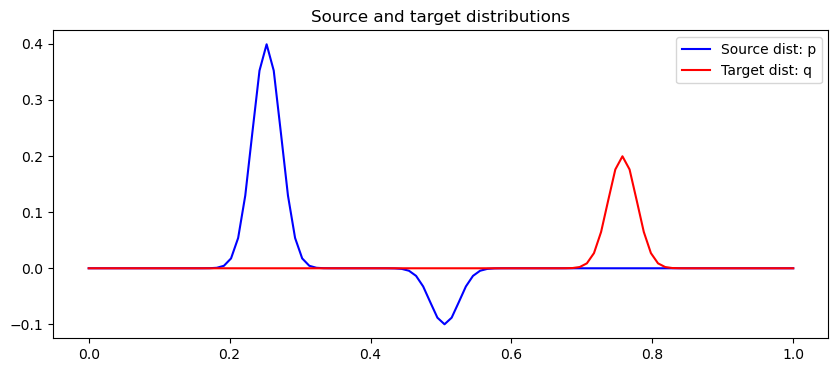

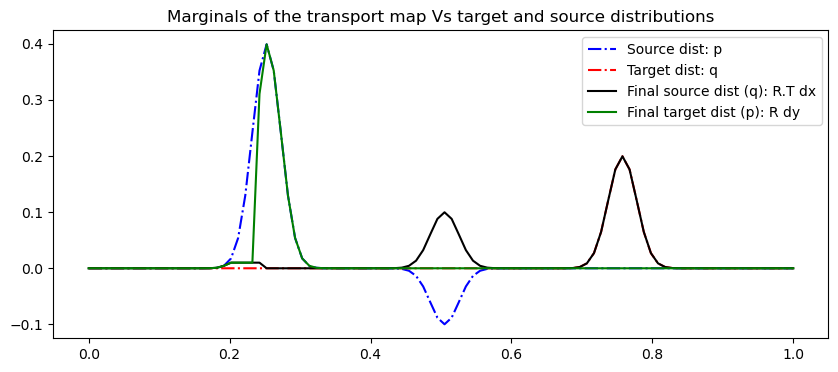

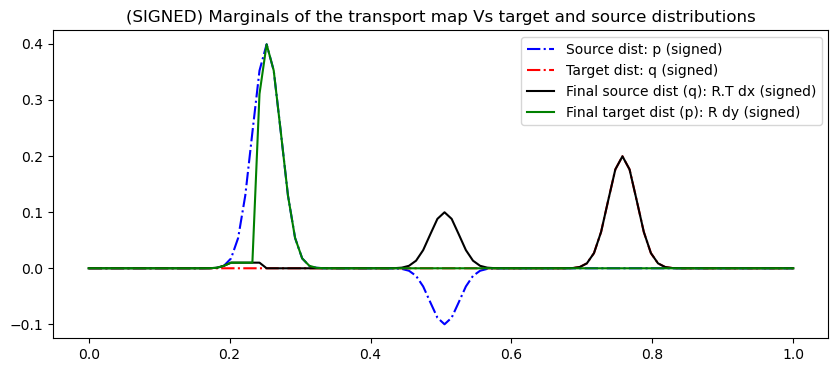

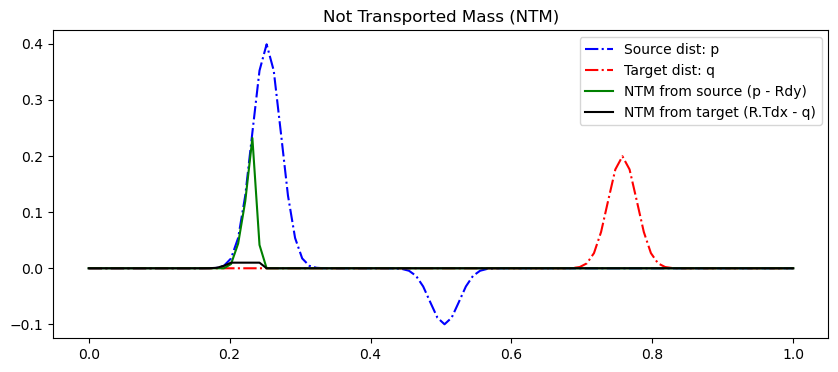

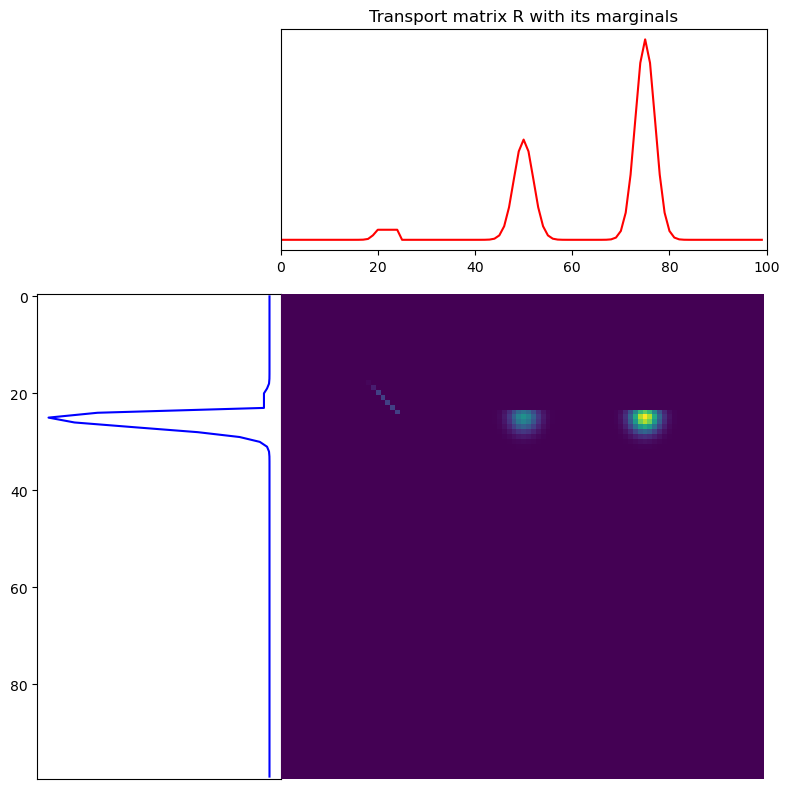

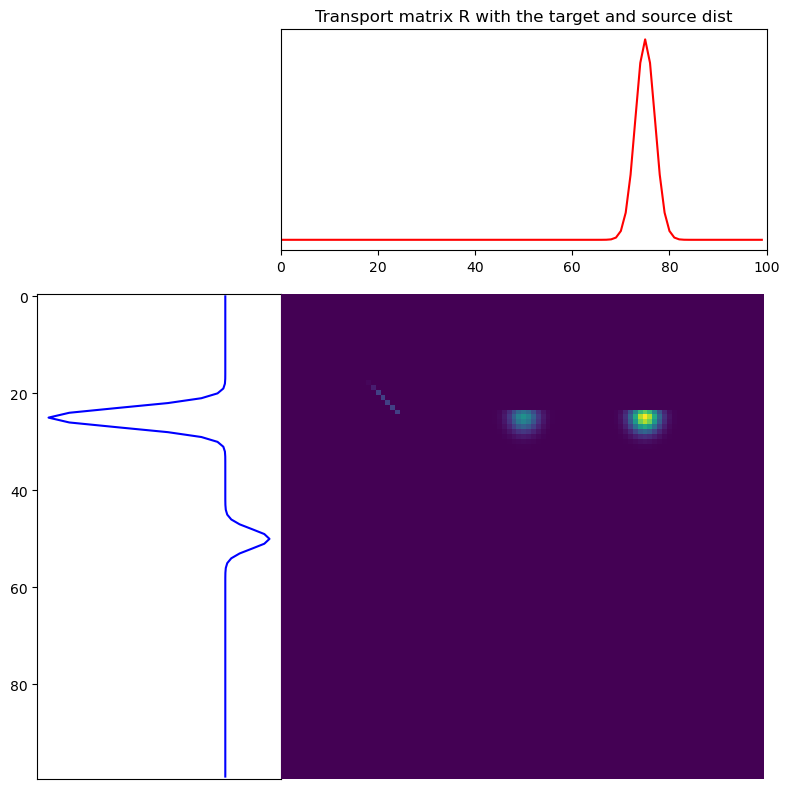

In [14]:
#--------------------------------------#
# Print info
if np.isscalar(eps_vec):
    eps = eps_vec
else:
    eps = eps_vec[-1] # select the last epsilon to use
    
K_t = np.exp(C/(-eps))
F = Fun[0] 
param_p = [lda]
nI = n_p ; nJ = n_q

## To work with the signed measures
p_pos = np.zeros(p.shape)
p_neg = np.zeros(p.shape)
q_pos = np.zeros(q.shape)
q_neg = np.zeros(q.shape)

sign_p = np.sign(p)
sign_q = np.sign(q)

p_pos[sign_p>0] = p[sign_p>0]
p_neg[sign_p<0] = -p[sign_p<0]
q_pos[sign_q>0] = q[sign_q>0]
q_neg[sign_q<0] = -q[sign_q<0]

p_tilde = p_pos + q_neg
q_tilde = q_pos + p_neg
##

primal = fdiv(F,R@dy,p,dx,param_p) + fdiv(F,R.T@dx,q,dy,param_p) + \
    eps/(nI*nJ) * np.sum( mul0(R , np.log(div0(R,K_t))) - R + K_t )
dual = - fdiv_c(F,-eps*np.log(a_t),p,dx,param_p) - fdiv_c(F,-eps*np.log(b_t),q,dy,param_p) -\
    eps/(nI*nJ) * np.sum(R-K_t)
pdgap = primal-dual

transp_cost = np.sum((np.diag(np.reshape(dx,-1))@(R*C))@np.diag(np.reshape(dy,-1)))
creat_cost = fdiv(F,R@dy,p_tilde,dx,param_p) + fdiv(F,R.T@dx,q_tilde,dy,param_p)
Wdist = transp_cost + creat_cost

print('*******************')
print('Transport details:')
print('W distance = %e'%(Wdist))
print('Transport cost = %e , Creat/dest cost = %e'%(transp_cost,creat_cost))
print('Elements transported = %d'%(np.count_nonzero(R - np.diag(np.diagonal(R)))))
print('target |q - R.Tdx|_1 = %f'%(np.sum(abs(q-R.T@dx))))
print('source |p - Rdy|_1 = %f'%(np.sum(abs(p-R@dy))))
print('Int(p) = %.2f , |p| = %.2f'%(np.sum(p),np.sum(abs(p))))
print('Int(q) = %.2f , |q| = %.2f'%(np.sum(q),np.sum(abs(q))))
print('primal = %e , dual = %e , gap = %e'%(primal,dual,pdgap))
print('*******************')


#--------------------------------------#
# Plots

# target and source distributions
plt.figure( figsize=(10, 4))
plt.plot(X,p, 'b-', label='Source dist: p')
plt.plot(Y,q, 'r-', label='Target dist: q')
plt.legend()
plt.title('Source and target distributions')

# Marginals of the transport map
# target and source distributions
plt.figure( figsize=(10, 4))
plt.plot(X,p, 'b-.', label='Source dist: p')
plt.plot(Y,q, 'r-.', label='Target dist: q')
plt.plot(X, R.T@dx, 'k-', label='Final source dist (q): R.T dx')
plt.plot(Y, R@dy, 'g-', label='Final target dist (p): R dy')
plt.legend()
plt.title('Marginals of the transport map Vs target and source distributions')

# Marginals of the transport map -_> for the signed measures
# target and source distributions
plt.figure( figsize=(10, 4))
plt.plot(X,p, 'b-.', label='Source dist: p (signed)')
plt.plot(Y,q, 'r-.', label='Target dist: q (signed)')
plt.plot(X, (R.T@dx)*np.sign(q), 'k-', label='Final source dist (q): R.T dx (signed)')
plt.plot(Y, (R@dy)*np.sign(p), 'g-', label='Final target dist (p): R dy (signed)')
plt.legend()
plt.title('(SIGNED) Marginals of the transport map Vs target and source distributions')

# not transported mass
# Positive value means mass that is left over.
# Negative values means that mass is missing.
plt.figure( figsize=(10, 4))
plt.plot(X,p, 'b-.', label='Source dist: p')
plt.plot(Y,q, 'r-.', label='Target dist: q')
plt.plot(X, p_tilde - R@dy, 'g-', label='NTM from source (p - Rdy)')
plt.plot(Y, R.T@dx - q_tilde, 'k-', label='NTM from target (R.Tdx - q)')
plt.legend()
plt.title('Not Transported Mass (NTM)')

# Plot transport plan with its marginals
plt.figure( figsize=(8, 8))
plot1D_mat(R@dy, R.T@dx, R, 'Transport matrix R with its marginals')

# Plot transport plan with its marginals
plt.figure( figsize=(8, 8))
plot1D_mat(p, q, R, 'Transport matrix R with the target and source dist')



Text(0.5, 1.0, '(SIGNED) Marginals of the transport map Vs target and source distributions')

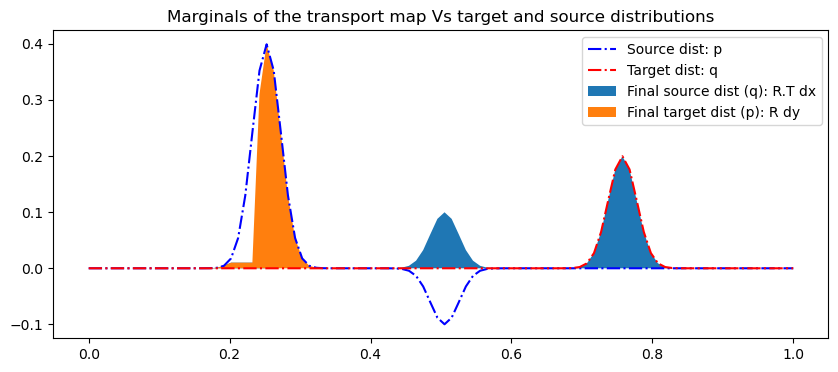

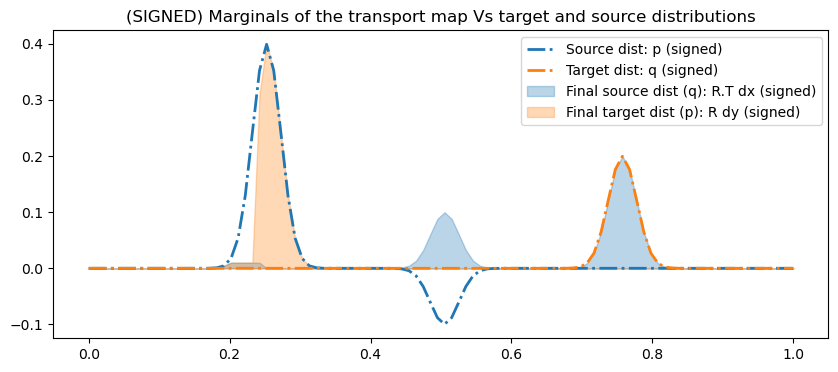

In [15]:
# Marginals of the transport map
# target and source distributions
plt.figure( figsize=(10, 4))
plt.plot(X,p, 'b-.', label='Source dist: p')
plt.plot(Y,q, 'r-.', label='Target dist: q')
plt.fill_between(X, (R.T@dx)[:,0], 0, label='Final source dist (q): R.T dx')
plt.fill_between(Y, (R@dy)[:,0], 0, label='Final target dist (p): R dy')
plt.legend()
plt.title('Marginals of the transport map Vs target and source distributions')

# Marginals of the transport map -_> for the signed measures
# target and source distributions
plt.figure( figsize=(10, 4))
plt.plot(X,p, '-.', color='C0', linewidth=2, label='Source dist: p (signed)')
plt.plot(Y,q, '-.', color='C1', linewidth=2, label='Target dist: q (signed)')
plt.fill_between(X, (R.T@dx)[:,0]*np.sign(q)[:,0], 0, color='C0', alpha=.3 , label='Final source dist (q): R.T dx (signed)')
plt.fill_between(Y, (R@dy)[:,0]*np.sign(p)[:,0], 0, color='C1', alpha=.3 , label='Final target dist (p): R dy (signed)')
plt.legend()
plt.title('(SIGNED) Marginals of the transport map Vs target and source distributions')

# Test transition

In [16]:
def test_transition(n_ex,lda_start,lda_fin,n_elems):

    n_p = 100
    n_q = 100
    n_max = 50000
    #eps_vec = 1.e-3
    X,Y = np.linspace(0,1,n_p), np.linspace(0,1,n_q)

    # Choose the transport example
    #n_ex = 4

    # Transportation examples
    if n_ex == 1:
        # Example N1: no transport at all
        eps_vec = np.logspace(-2.,-6.,10)
        lda = 1.e0
        p =  make_1D_gauss(n_p, np.floor(1*n_p/4.), 2.)*(-1) 
        q =  make_1D_gauss(n_q, np.floor(7*n_q/8.), 2.)*1 

    elif n_ex == 2:
        # Example N2: positive transport
        eps_vec = np.logspace(-2.,-6.,10)
        lda = 1.e0
        p =  make_1D_gauss(n_p, np.floor(2*n_p/4.), 2.)*1 + make_1D_gauss(n_p, np.floor(2*n_p/4.), 2.)*1
        q =  make_1D_gauss(n_q, np.floor(2*n_q/8.), 2.)*1 + make_1D_gauss(n_q, np.floor(6*n_q/8.), 2.)*1 

    elif n_ex == 3:
        # Example N3: transport + destruction
        eps_vec = np.logspace(-2.,-6.,10)
        lda = 1.e0
        p =  make_1D_gauss(n_p, np.floor(1*n_p/4.), 2.)*(2) + make_1D_gauss(n_p, np.floor(2*n_p/4.), 2.)*(0.5) 
        q =  make_1D_gauss(n_q, np.floor(6*n_q/8.), 2.)*1

    elif n_ex == 4:
        # Example N4: cancelation + transport
        eps_vec = np.logspace(-2.,-4.,10)
        lda = 1.e-3
        p =  make_1D_gauss(n_p, np.floor(2*n_p/8.), 2.)*(2) + make_1D_gauss(n_p, np.floor(4*n_p/8.), 2.)*(-1) 
        q =  make_1D_gauss(n_q, np.floor(6*n_q/8.), 2.)*1

    elif n_ex == 5:
        # Example N5: cancelation + creation
        eps_vec = np.logspace(-2.,-4.,10)
        lda = 1.e0
        p =  make_1D_gauss(n_p, np.floor(1*n_p/8.), 2.)*(1) + make_1D_gauss(n_p, np.floor(2.5*n_p/8.), 2.)*(-1) 
        q =  make_1D_gauss(n_q, np.floor(7*n_q/8.), 2.)*1  #+ make_1D_gauss(n_p, np.floor(5.5*n_p/8.), 2.)*(-1)

    elif n_ex == 6:
        # Example N3: transport + destruction
        eps_vec = np.logspace(-1.,-3.,10)
        lda = 1.e0
        p =  make_1D_gauss(n_p, np.floor(1*n_p/4.), 2.)*(0.5) + make_1D_gauss(n_p, np.floor(2*n_p/4.), 2.)*(0.5) 
        q =  make_1D_gauss(n_q, np.floor(6*n_q/8.), 2.)*1


    # Define the lambdas
    ldas = np.linspace(lda_start,lda_fin,n_elems)
     
    #************************************#
    # Computations
    dx = np.ones([n_p,1])/n_p
    dy = np.ones([n_q,1])/n_q

    C = np.zeros([n_p,n_q],dtype=np.float64)

    dist_f2 = lambda a,b : (a-b)**2
    dist_f1 = lambda a,b : abs(a-b)
    dist_fcos = lambda a,b : -2*np.log(np.cos(np.pi*0.5*np.minimum(1.,np.abs(a-b)/.2)))
    #dist_fcos = lambda a,b : np.minimum(1.,np.abs(a-b)/.2)

    for it1 in range(n_p):
        for it2 in range(n_q):
            C[it1,it2] = dist_f1(X[it1],Y[it2])
       
    # Main iteration
    Rs = np.zeros([n_p,n_q,n_elems])
    a_ts = np.zeros([n_p,1,n_elems])
    b_ts = np.zeros([n_q,1,n_elems])
    
    for it in range(n_elems):
        lda = ldas[it]
        Fun = ['TV', lda] # The constraints have to be 'TV' in order to work with signed measures.    

        R, a_t, b_t, primals, duals, pdgaps = signed_GWD(C,Fun,p,q,eps_vec,dx,dy,n_max)
        Rs[:,:,it] = R
        a_ts[:,:,it] = a_t
        b_ts[:,:,it] = b_t


    #--------------------------------------#
    # Plots

    # target and source distributions
    plt.figure( figsize=(10, 4))
    plt.plot(X,p, 'b-', label='Source dist: p')
    plt.plot(Y,q, 'r-', label='Target dist: q')
    plt.legend()
    plt.title('Source and target distributions')

    # Marginals of the transport map
    # target and source distributions
    for it in range(n_elems):
        lbl1 = 'Source dist (q): R.T dx. Lda = ' + str(ldas[it])
        lbl2 = 'Target dist (p): R dy. Lda = ' + str(ldas[it])
        plt.figure( figsize=(10, 4))
        plt.plot(X,p, 'b-.', label='Source dist: p')
        plt.plot(Y,q, 'r-.', label='Target dist: q')
        plt.plot(X, Rs[:,:,it].T@dx, '-', label=lbl1)
        plt.plot(Y, Rs[:,:,it]@dy, '-', label=lbl2)
        plt.legend()
        plt.title('Marginals of the transport map Vs target and source distributions')       

        
    return Rs
        
        
        

it = 5001 , eps = 0.059948
it = 10001 , eps = 0.035938
it = 15001 , eps = 0.021544
it = 20001 , eps = 0.012915
it = 25001 , eps = 0.007743
it = 30001 , eps = 0.004642
it = 35001 , eps = 0.002783
it = 40001 , eps = 0.001668
it = 45001 , eps = 0.001000


/var/folders/hj/cjr82nxn52g6pymvdqp74p5m0000gp/T/ipykernel_80827/3890346337.py:61: RuntimeWarning: divide by zero encountered in log
  eps/(nI*nJ) * np.sum( mul0(R , np.log(div0(R,K_t))) - R + K_t )


it = 5001 , eps = 0.059948
it = 10001 , eps = 0.035938
it = 15001 , eps = 0.021544
it = 20001 , eps = 0.012915
it = 25001 , eps = 0.007743
it = 30001 , eps = 0.004642
it = 35001 , eps = 0.002783
it = 40001 , eps = 0.001668
it = 45001 , eps = 0.001000
it = 5001 , eps = 0.059948
it = 10001 , eps = 0.035938
it = 15001 , eps = 0.021544
it = 20001 , eps = 0.012915
it = 25001 , eps = 0.007743
it = 30001 , eps = 0.004642
it = 35001 , eps = 0.002783
it = 40001 , eps = 0.001668
it = 45001 , eps = 0.001000
it = 5001 , eps = 0.059948
it = 10001 , eps = 0.035938
it = 15001 , eps = 0.021544
it = 20001 , eps = 0.012915
it = 25001 , eps = 0.007743
it = 30001 , eps = 0.004642
it = 35001 , eps = 0.002783
it = 40001 , eps = 0.001668
it = 45001 , eps = 0.001000
it = 5001 , eps = 0.059948
it = 10001 , eps = 0.035938
it = 15001 , eps = 0.021544
it = 20001 , eps = 0.012915
it = 25001 , eps = 0.007743
it = 30001 , eps = 0.004642
it = 35001 , eps = 0.002783
it = 40001 , eps = 0.001668
it = 45001 , eps = 0.001

/var/folders/hj/cjr82nxn52g6pymvdqp74p5m0000gp/T/ipykernel_80827/3683799544.py:105: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure( figsize=(10, 4))


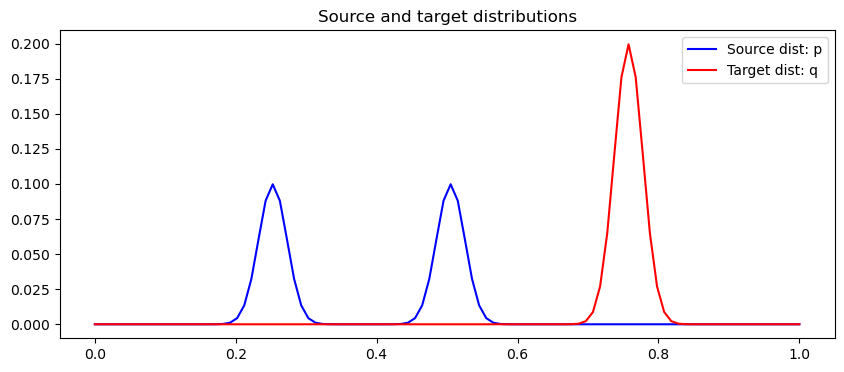

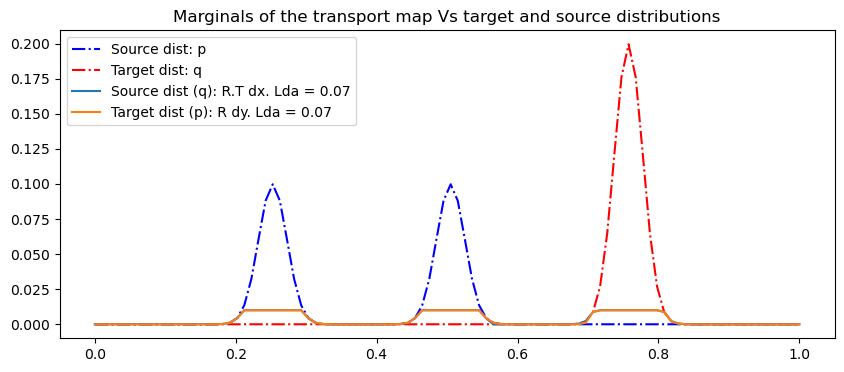

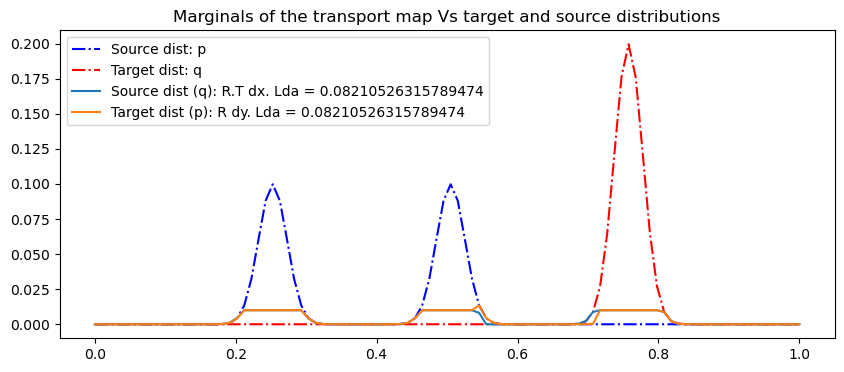

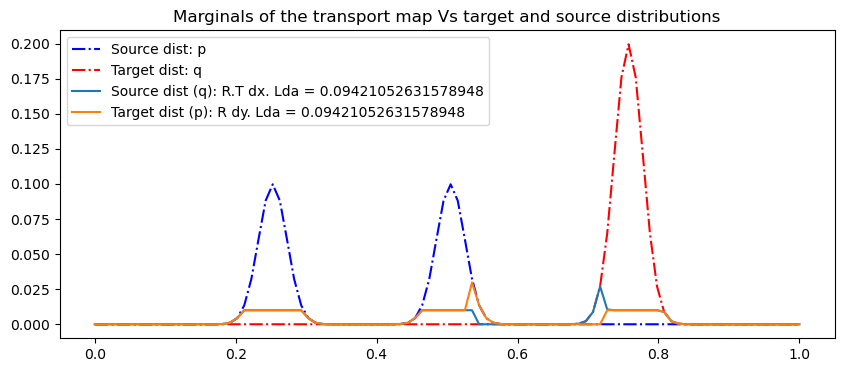

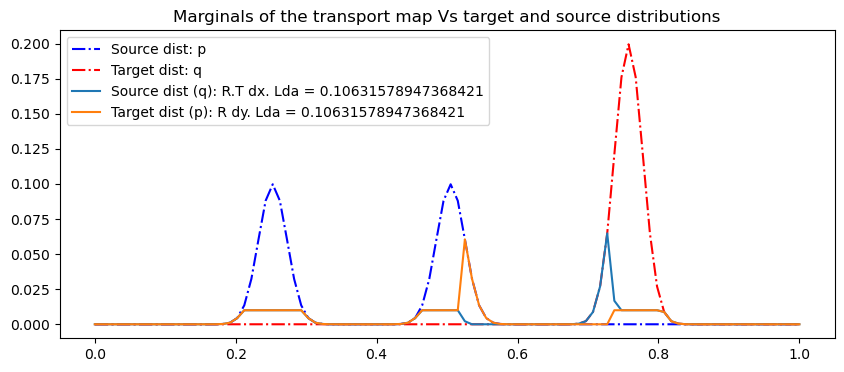

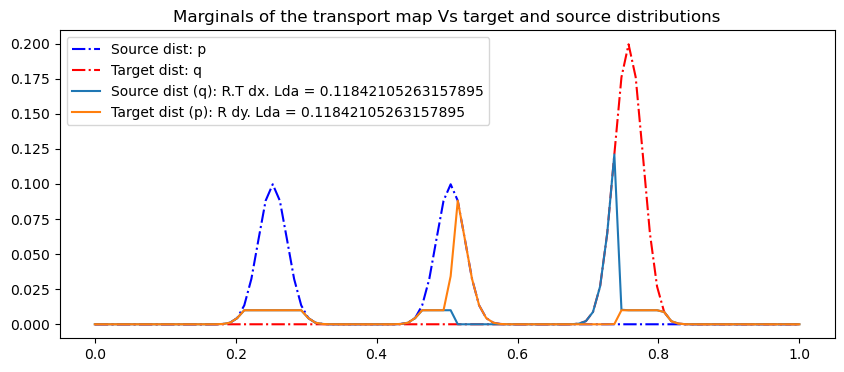

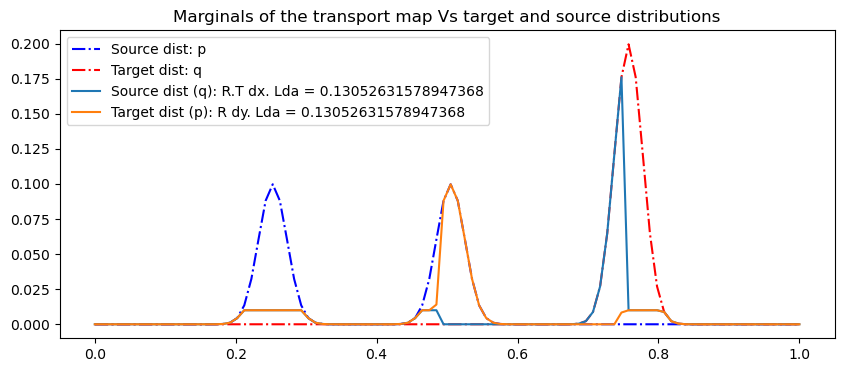

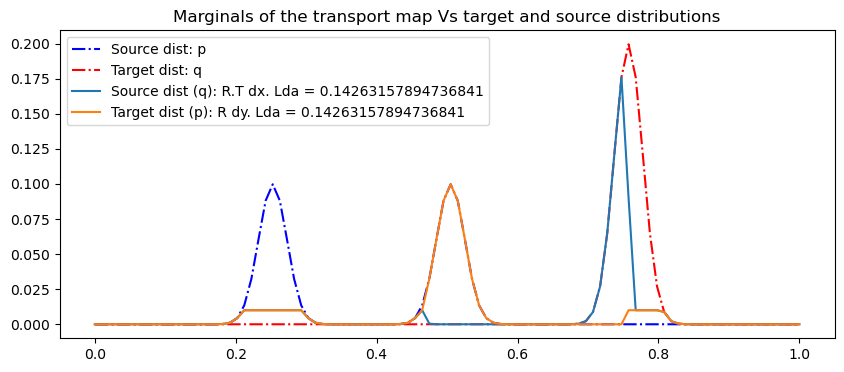

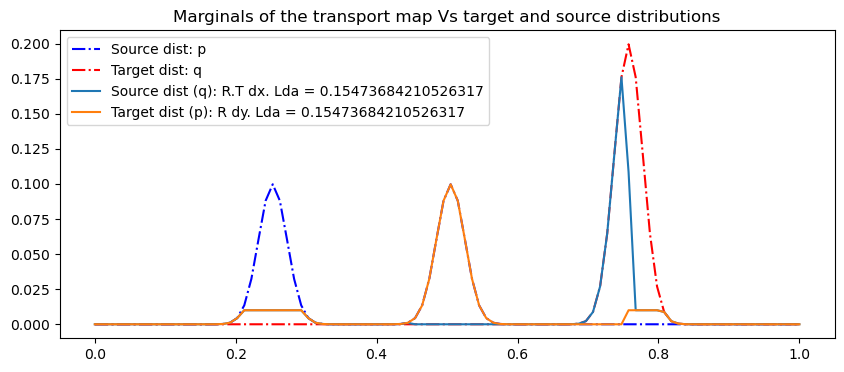

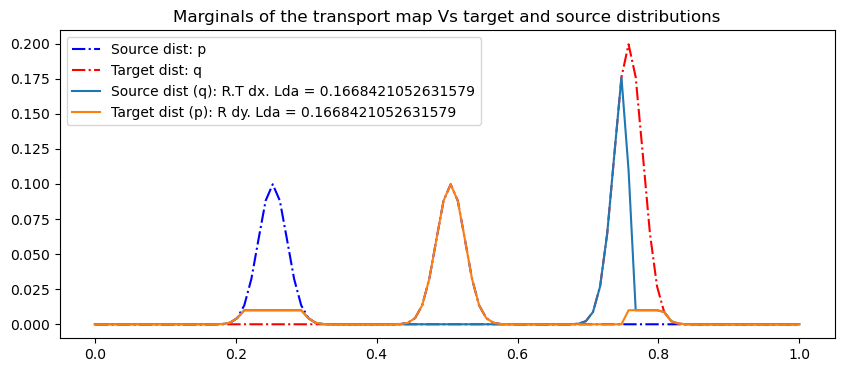

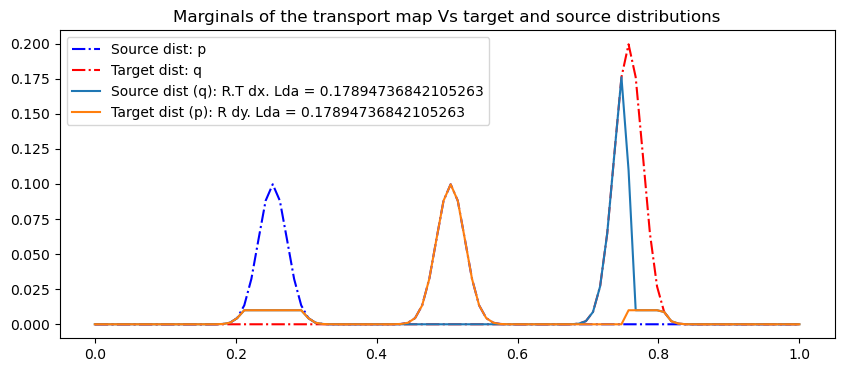

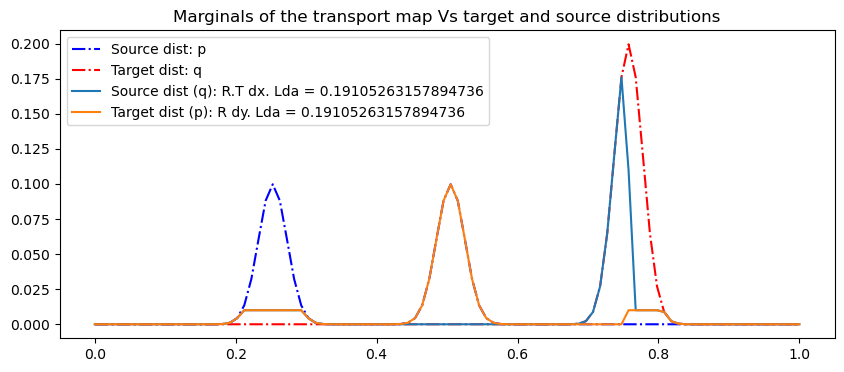

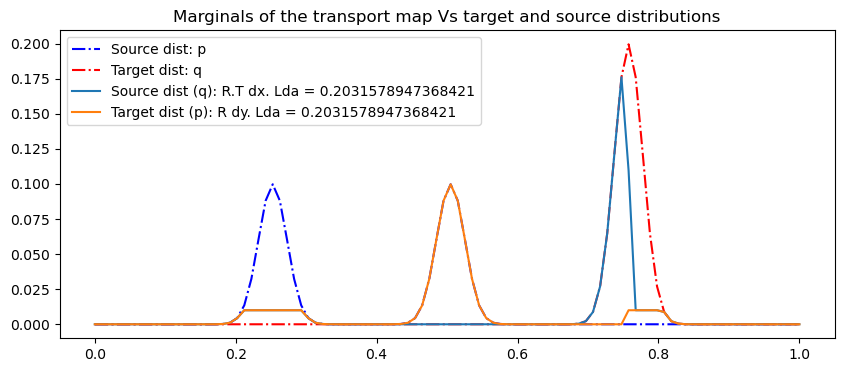

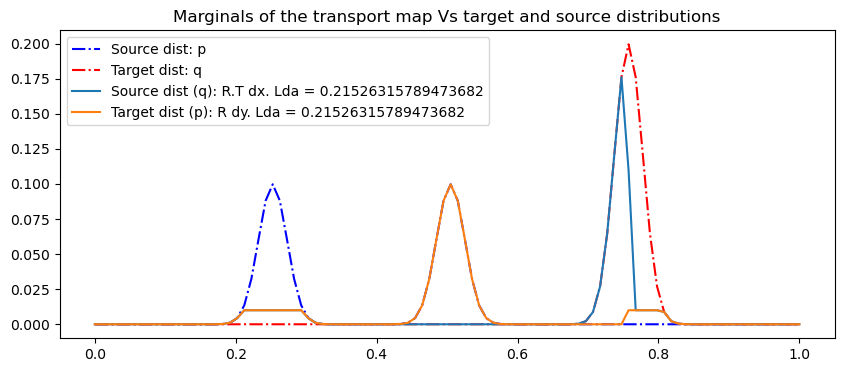

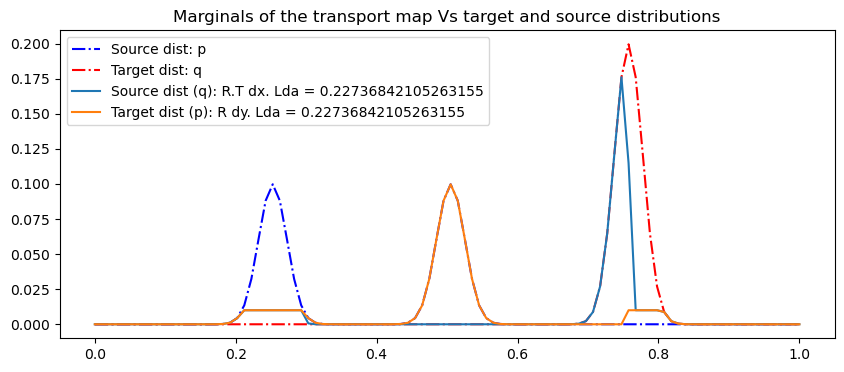

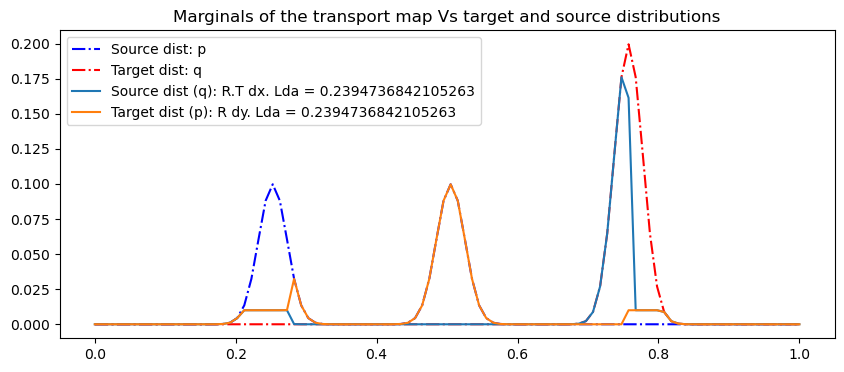

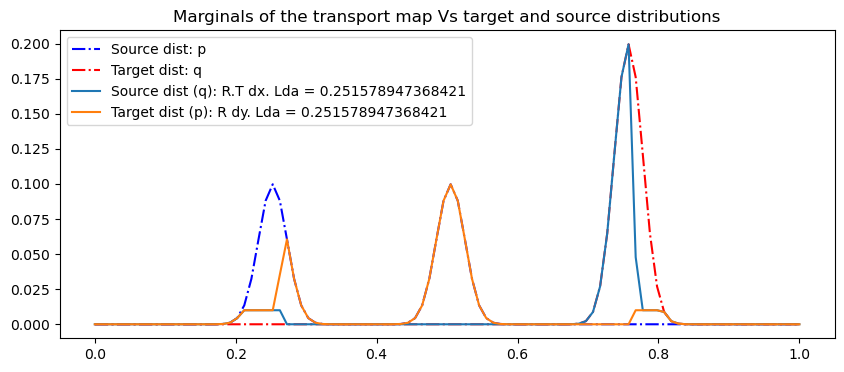

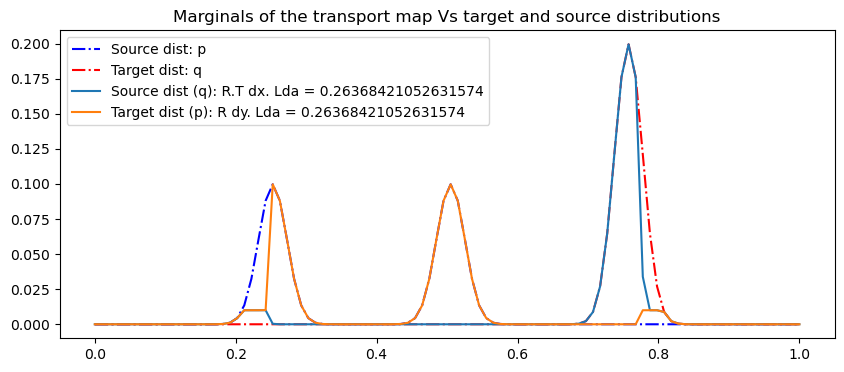

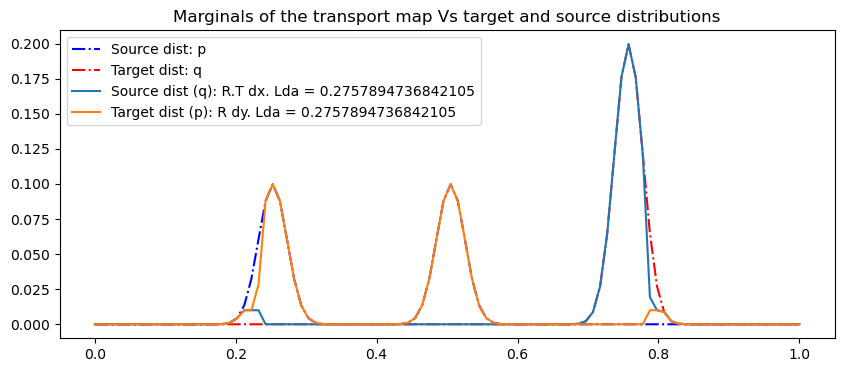

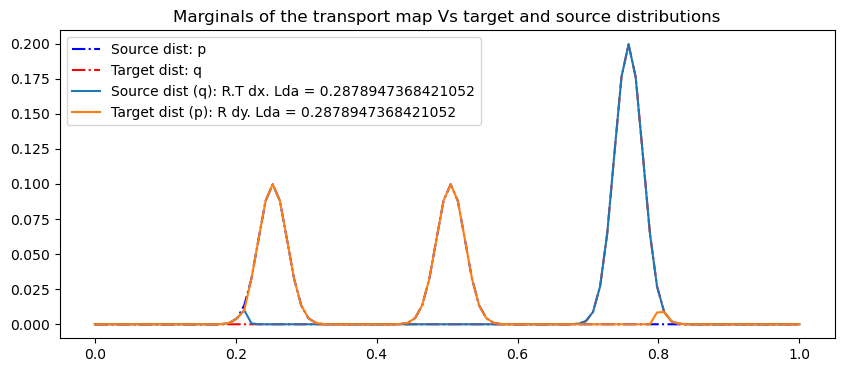

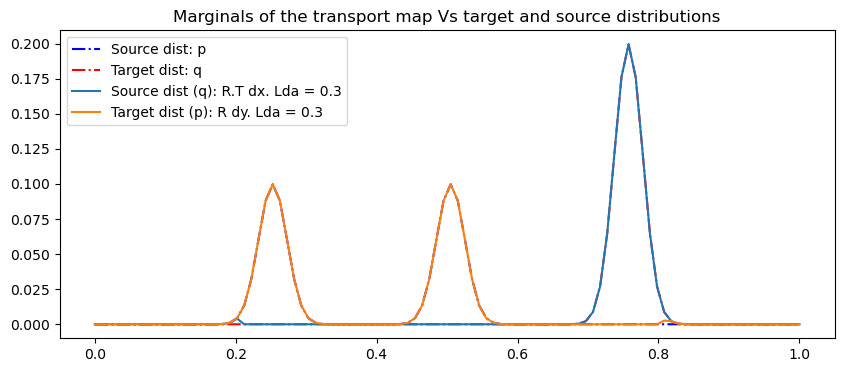

In [17]:
R_s_test = test_transition(n_ex=6,lda_start=0.07,lda_fin=0.3,n_elems=20)

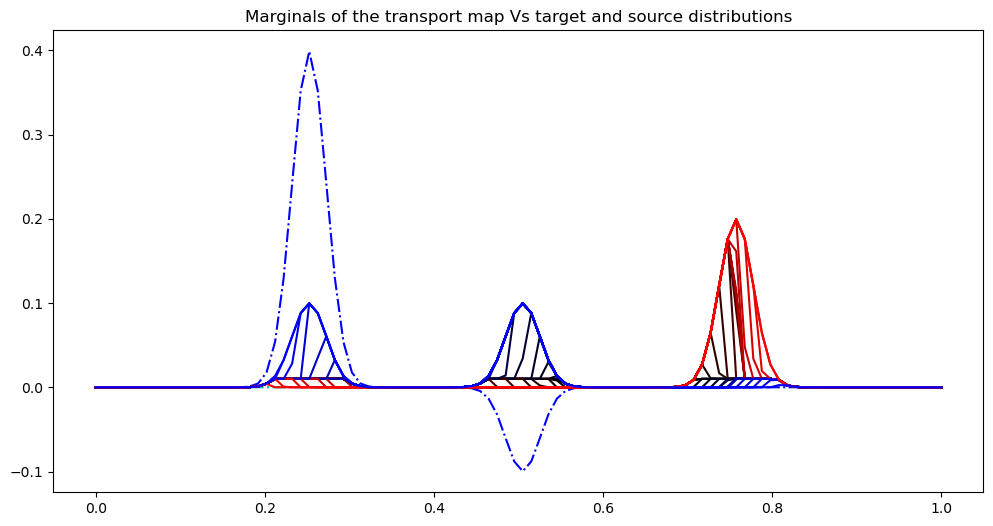

In [18]:
n_ex=6
lda_start=0.07
lda_fin=0.3
n_elems=20

n_p = 100
n_q = 100
n_max = 50000
#eps_vec = 1.e-3
X,Y = np.linspace(0,1,n_p), np.linspace(0,1,n_q)

# Define the lambdas
ldas = np.linspace(lda_start,lda_fin,n_elems)

# Computations
dx = np.ones([n_p,1])/n_p
dy = np.ones([n_q,1])/n_q

# Marginals of the transport map
# target and source distributions

color_shade = np.linspace(0.0,1.0,n_elems)

plt.figure( figsize=(12, 6))
plt.plot(X,p, 'b-.', label='Source dist: p')
plt.plot(Y,q, 'c-.', label='Target dist: q')
for it in range(n_elems):
    lbl1 = 'Src: Lda = ' + str(ldas[it])
    lbl2 = 'Tgt: Lda = ' + str(ldas[it])

    plt.plot(X, R_s_test[:,:,it].T@dx, '-', label=lbl1,color=(color_shade[it],0.0,0.0))
    plt.plot(Y, R_s_test[:,:,it]@dy, '-', label=lbl2,color=(0.0,0.0,color_shade[it]))
    #plt.legend()
    plt.title('Marginals of the transport map Vs target and source distributions')       


Text(0.5, 1.0, 'Source and target distributions')

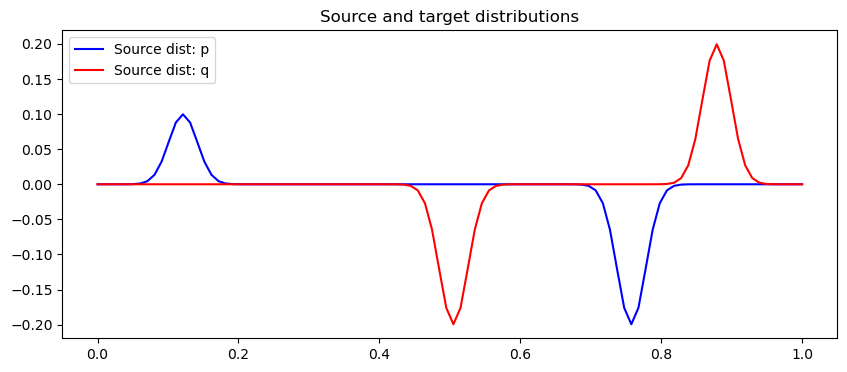

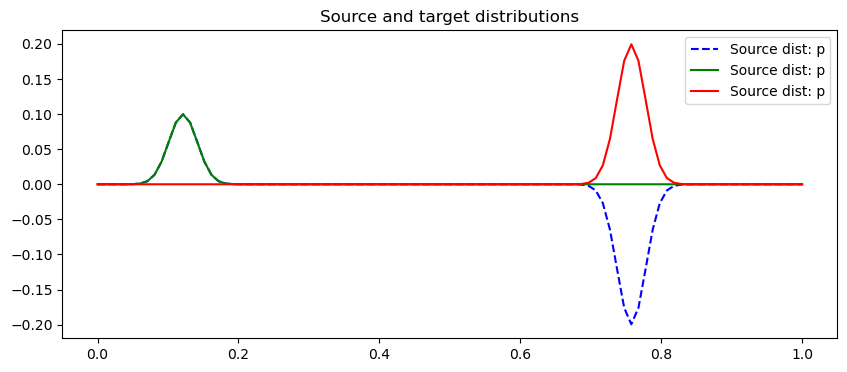

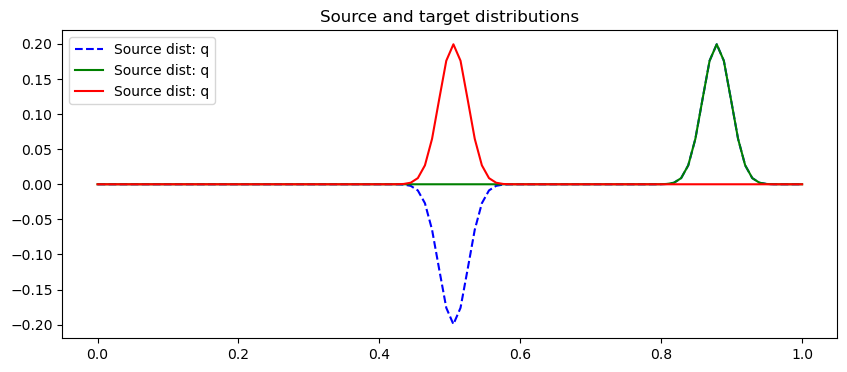

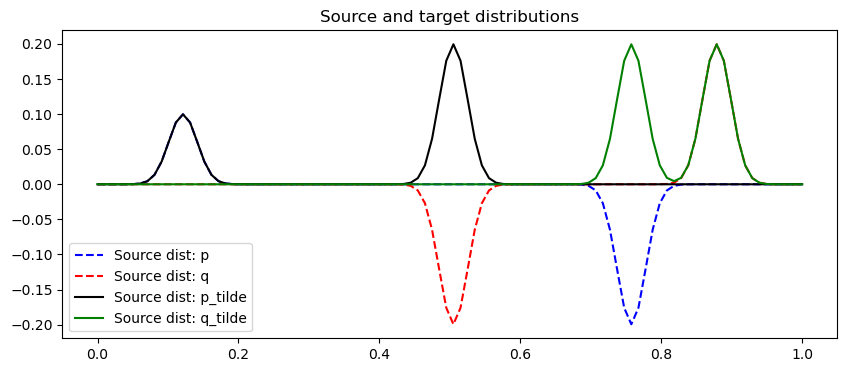

In [19]:
# NOT FINISHED

# Script to check the partitions made

# define the input (signed) distributions
p =  make_1D_gauss(n_p, np.floor(3*n_p/4.), 2.)*(-1) + make_1D_gauss(n_p, np.floor(1*n_p/8.), 2.)*0.5
q =  make_1D_gauss(n_q, np.floor(7*n_q/8.), 2.)*1 + make_1D_gauss(n_q, np.floor(4*n_q/8.), 2.)*(-1)

# partitioning
p_pos = np.zeros(p.shape)
p_neg = np.zeros(p.shape)
q_pos = np.zeros(q.shape)
q_neg = np.zeros(q.shape)

sign_p = np.sign(p)
sign_q = np.sign(q)

p_pos[sign_p>0] = p[sign_p>0]
p_neg[sign_p<0] = -p[sign_p<0]
q_pos[sign_q>0] = q[sign_q>0]
q_neg[sign_q<0] = -q[sign_q<0]

p_tilde = p_pos + q_neg
q_tilde = q_pos + p_neg

#---------#
# Plot
# target and source distributions
plt.figure( figsize=(10, 4))
plt.plot(X,p, 'b-', label='Source dist: p')
plt.plot(X,q, 'r-', label='Source dist: q')
plt.legend()
plt.title('Source and target distributions')

# target and source distributions
plt.figure( figsize=(10, 4))
plt.plot(X,p, 'b--', label='Source dist: p')
plt.plot(X,p_pos, 'g-', label='Source dist: p')
plt.plot(X,p_neg, 'r-', label='Source dist: p')
plt.legend()
plt.title('Source and target distributions')

# target and source distributions
plt.figure( figsize=(10, 4))
plt.plot(X,q, 'b--', label='Source dist: q')
plt.plot(X,q_pos, 'g-', label='Source dist: q')
plt.plot(X,q_neg, 'r-', label='Source dist: q')
plt.legend()
plt.title('Source and target distributions')

# target and source distributions
plt.figure( figsize=(10, 4))
plt.plot(X,p, 'b--', label='Source dist: p')
plt.plot(X,q, 'r--', label='Source dist: q')
plt.plot(X,p_tilde, 'k-', label='Source dist: p_tilde')
plt.plot(X,q_tilde, 'g-', label='Source dist: q_tilde')
plt.legend()
plt.title('Source and target distributions')